In [1]:
import warnings
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt

from os.path import join
from IPython import display
from sklearn.datasets import load_digits
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, homogeneity_score, completeness_score, v_measure_score # и другие метрики
from sklearn.metrics.cluster import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.cluster import KMeans # а также другие алгоритмы
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import chi2_kernel
from sklearn.cluster import Birch, DBSCAN, BisectingKMeans, MiniBatchKMeans, SpectralClustering

In [2]:
DATA_PATH = "../data"
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Задание 1. Реализация Kmeans

5 баллов

В данном задании вам предстоит дописать код класса `MyKMeans`. Мы на простом примере увидим, как подбираются центры кластеров и научимся их визуализировать.

Сгенерируем простой набор данных, 400 объектов и 2 признака (чтобы все быстро работало и можно было легко нарисовать):

In [3]:
X, true_labels = make_blobs(400, 2, centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]])

Напишем функцию `visualize_clusters`, которая по данным и меткам кластеров будет рисовать их и разукрашивать:

In [4]:
def visualize_clusters(X, labels):
    """
    Функция для визуализации кластеров
        :param X: таблица объекты х признаки
        :param labels: np.array[n_samples] - номера кластеров
    """
    
    unique_labels = np.sort(np.unique(labels))
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=labels, 
                    palette=sns.color_palette("RdPu")[1:], legend=False,
                    hue_order=unique_labels)
    plt.xlabel("$X_1$", fontsize=18)
    plt.ylabel("$X_2$", fontsize=18)
    
    for label in labels:
        center = X[(labels == label)].mean(axis=0)
        plt.scatter(center[0], center[1], s=80, c="#201F12", marker=(5, 2))

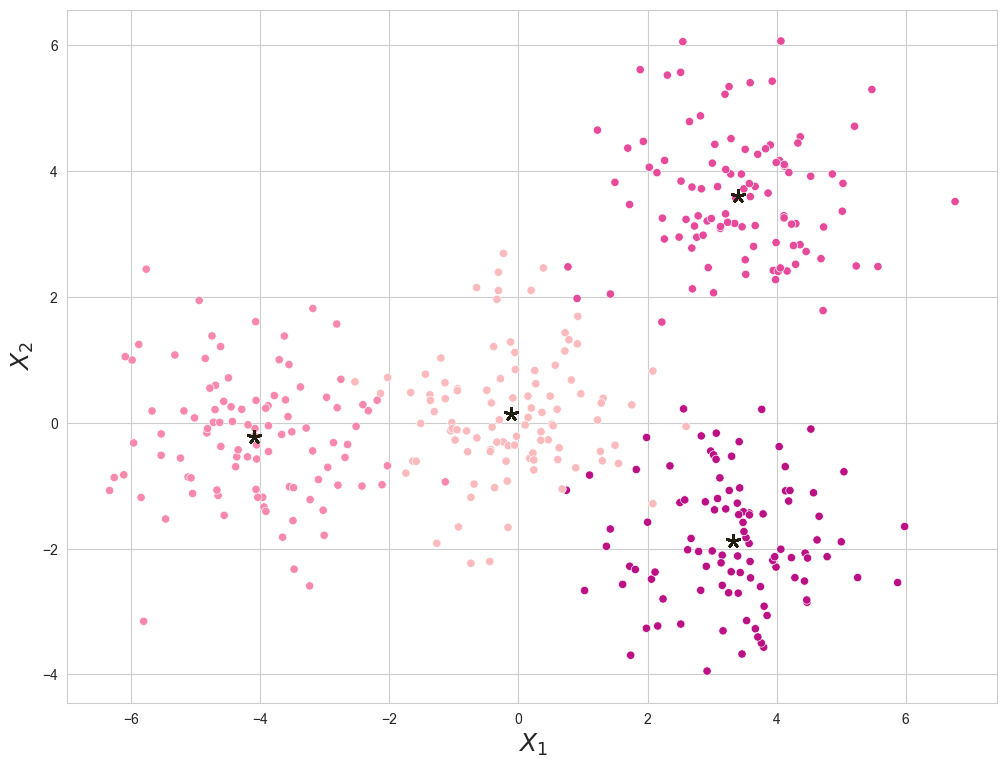

In [5]:
visualize_clusters(X, true_labels)

Напишем свой класс `MyKMeans`, который будет реализовывать алгоритм кластеризации K-средних. Напомним сам алгоритм:

1. Выбераем число кластеров (K)
2. Случайно инициализируем K точек (или выбираем из данных), это будут начальные центры наших кластеров
3. Далее для каждого объекта считаем расстояние до всех кластеров и присваиваем ему метку ближайщего
4. Далее для каждого кластера считаем "центр масс" (среднее значение для каждого признака по всем объектам кластера)
5. Этот "центр масс" становится новым центром кластера
6. Повторяем п.3, 4, 5 заданное число итераций или до сходимости

Во время предсказания алгоритм просто находит ближайщий центроид (центр кластера) для тестового объекта и возвращает его номер.

Реализуйте методы:
* `_calculate_distance(X, centroid)` - вычисляет Евклидово расстояние от всех объектов в `Х` до заданного центра кластера (`centroid`)
* `predict(X)` - для каждого элемента из `X` возвращает номер кластера, к которому относится данный элемент

In [6]:
class MyKMeans:
    def __init__(self, n_clusters, init="random", max_iter=300, visualize=False):
        """
        Конструктор класса MyKMeans
            :param n_clusters: число кластеров
            :param init: способ инициализации центров кластеров
                'random' - генерирует координаты случайно из нормального распределения
                'sample' - выбирает центроиды случайно из объектов выборки
            :param max_iter: заданное число итераций 
                (мы не будем реализовывать другой критерий остановки)
            :param visualize: рисовать ли кластеры и их центроиды в процессе работы
                код будет работать сильно дольше, но красиво...
        """
        
        assert init in ["random", "sample"], f"Неизвестный метод инициализации {init}"
        self.n_clusters = n_clusters
        self.init = init
        self.max_iter = max_iter
        self.centroids = None
        self.visualize = visualize
       
    
    def fit(self, X):
        """
        Подбирает оптимальные центры кластеров
            :param X: наши данные (n_samples, n_features)
        :return self: все как в sklearn
        """
        
        n_samples, n_features = X.shape
        
        # Инициализация центров кластеров
        if self.init == "random":
            centroids = np.random.randn(self.n_clusters, n_features)
        elif self.init == "sample":
            centroids_idx = np.random.choice(np.arange(n_samples), 
                                             size=self.n_clusters, 
                                             replace=False)
            centroids = X[centroids_idx]
        
        # Итеративно двигаем центры
        for _ in range(self.max_iter):
            # Посчитаем расстояния для всех объектов до каждого центроида
            dists = []
            for centroid in centroids:
                dists.append(self._calculate_distance(X, centroid))
            dists = np.concatenate(dists, axis=1)
            # Для каждого объекта найдем, к какому центроиду он ближе
            cluster_labels = np.argmin(dists, axis=1)
            
            # Пересчитаем центр масс для каждого кластера
            centroids = []
            for label in np.sort(np.unique(cluster_labels)):
                center = X[(cluster_labels == label)].mean(axis=0)
                centroids.append(center)
            
            # Отрисуем точки, покрасим по меткам кластера, а также изобразим центроиды
            if self.visualize:
                visualize_clusters(X, cluster_labels)
                display.clear_output(wait=True)
                display.display(plt.gcf())
                plt.close()
                
        self.centroids = np.array(centroids)
        
        return self
    
    
    def predict(self, X):
        """
        Для каждого X возвращает номер кластера, к которому он относится
            :param X: наши данные (n_samples, n_features)
        :return cluster_labels: метки кластеров
        """
        
        """
        YOUR CODE IS HERE
        """
        dists = []
        for centroid in self.centroids:
            dists.append(self._calculate_distance(X, centroid))
        dists = np.concatenate(dists, axis=1)
        cluster_labels = np.argmin(dists, axis=1)
            
        return cluster_labels
        
        
    def _calculate_distance(self, X, centroid):
        """
        Вычисляет Евклидово расстояние от всех объектов в Х до заданного центра кластера (centroid)
            :param X: наши данные (n_samples, n_features)
            :param centroid: координаты центра кластера
        :return dist: расстояния от всех X до центра кластера
        """
        
        """
        YOUR CODE IS HERE
        """
        dist = np.sqrt(np.sum(np.square(X - centroid), axis=1)).reshape(-1, 1)
        
        return dist
    
    
    def __repr__(self):
        return f"Привет, я твой KMeans (/¯◡ ‿ ◡)/¯☆*"

Обучите `MyKMeans` на наших игручешных данных, добейтесь сходимости. Не забудьте поставить `visualize=True`, чтобы посмотреть на красивые картинки. Также попробуйте различные способы инициализации центроидов и скажите, какой лучше подошел в этой ситуации.

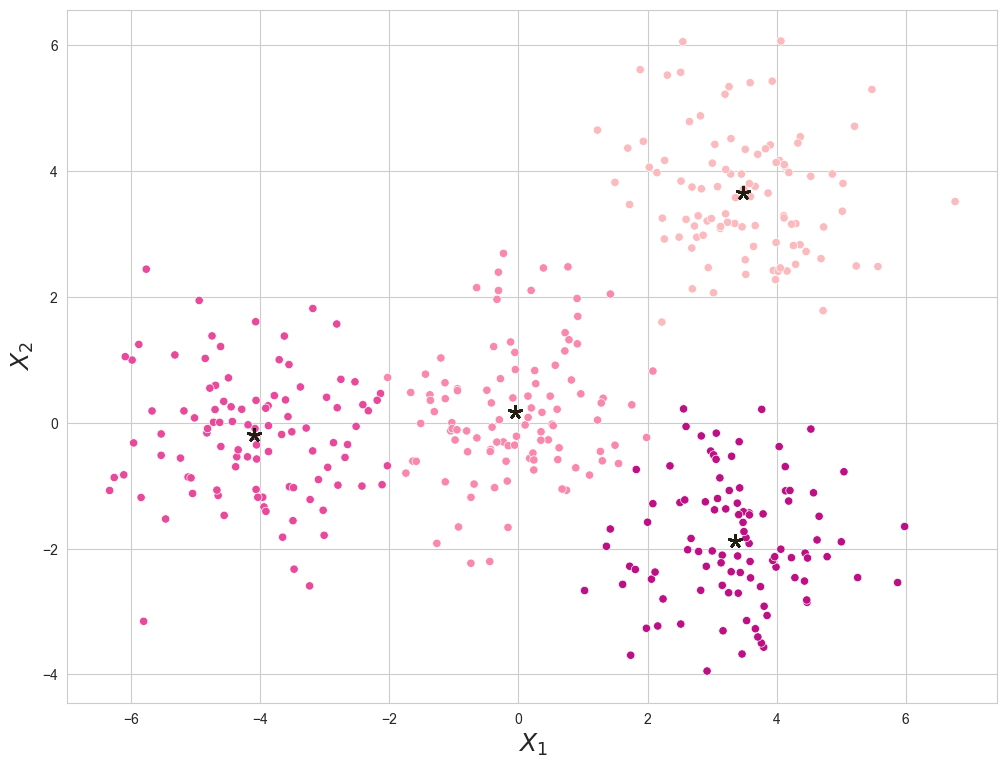

random initialization, 10 iterations:
The mean Silhouette Coefficient: 0.5643117184043004
Rand index adjusted for chance: 0.9278697796079957
Adjusted Mutual Information: 0.9051395864810662


In [7]:
initialization = "random"
iterations = 10

my_k_means_random = MyKMeans(n_clusters=4, visualize=True, init=initialization, max_iter=iterations)
my_k_means_random.fit(X)
pred_random = my_k_means_random.predict(X)

print(
    f'{initialization} initialization, {iterations} iterations:'
    '\n'
    f'The mean Silhouette Coefficient: {silhouette_score(X, pred_random)}'
    '\n'
    f'Rand index adjusted for chance: {adjusted_rand_score(true_labels, pred_random)}'
    '\n'
    f'Adjusted Mutual Information: {adjusted_mutual_info_score(true_labels, pred_random)}'
    )

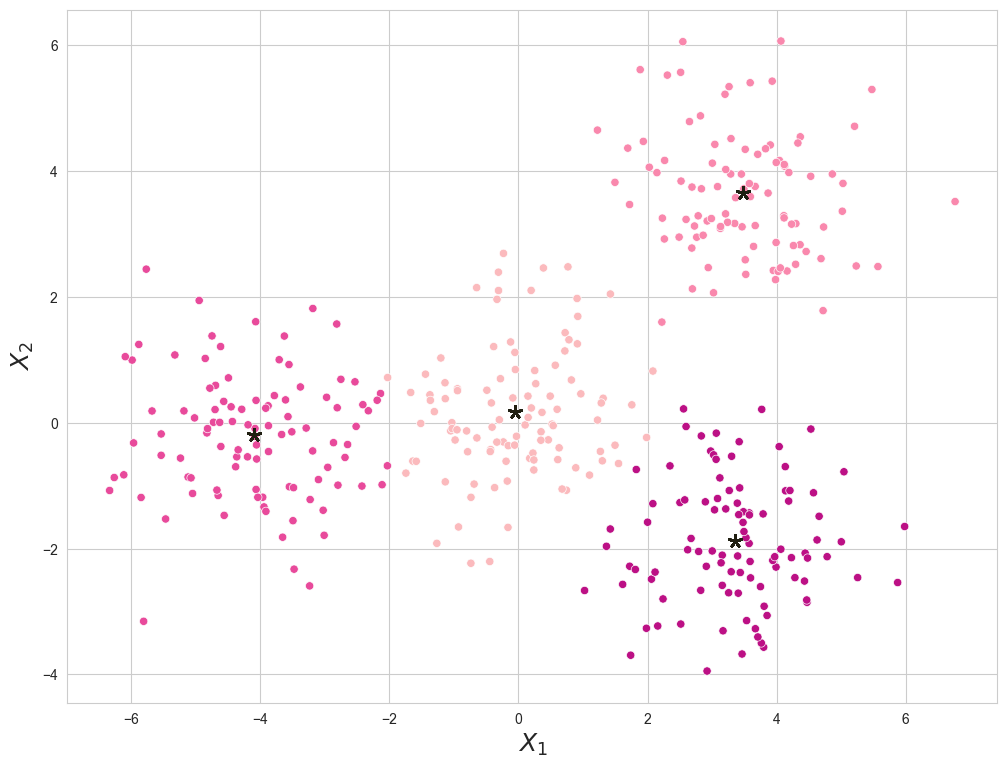

sample initialization, 10 iterations:
The mean Silhouette Coefficient: 0.5643117184043004
Rand index adjusted for chance: 0.9278697796079957
Adjusted Mutual Information: 0.9051395864810661


In [8]:
initialization = "sample"
iterations = 10

my_k_means_sample = MyKMeans(n_clusters=4, visualize=True, init=initialization, max_iter=iterations)
my_k_means_sample.fit(X)
pred_sample = my_k_means_sample.predict(X)

print(
    f'{initialization} initialization, {iterations} iterations:'
    '\n'
    f'The mean Silhouette Coefficient: {silhouette_score(X, pred_sample)}'
    '\n'
    f'Rand index adjusted for chance: {adjusted_rand_score(true_labels, pred_sample)}'
    '\n'
    f'Adjusted Mutual Information: {adjusted_mutual_info_score(true_labels, pred_sample)}'
    )

Here I took intentionally low iteration number (10) to show that on these data all three metrics are slightly higher if clustaers were initialized from sample points. However, the difference is extremely small. Let's try on 50 iterations.

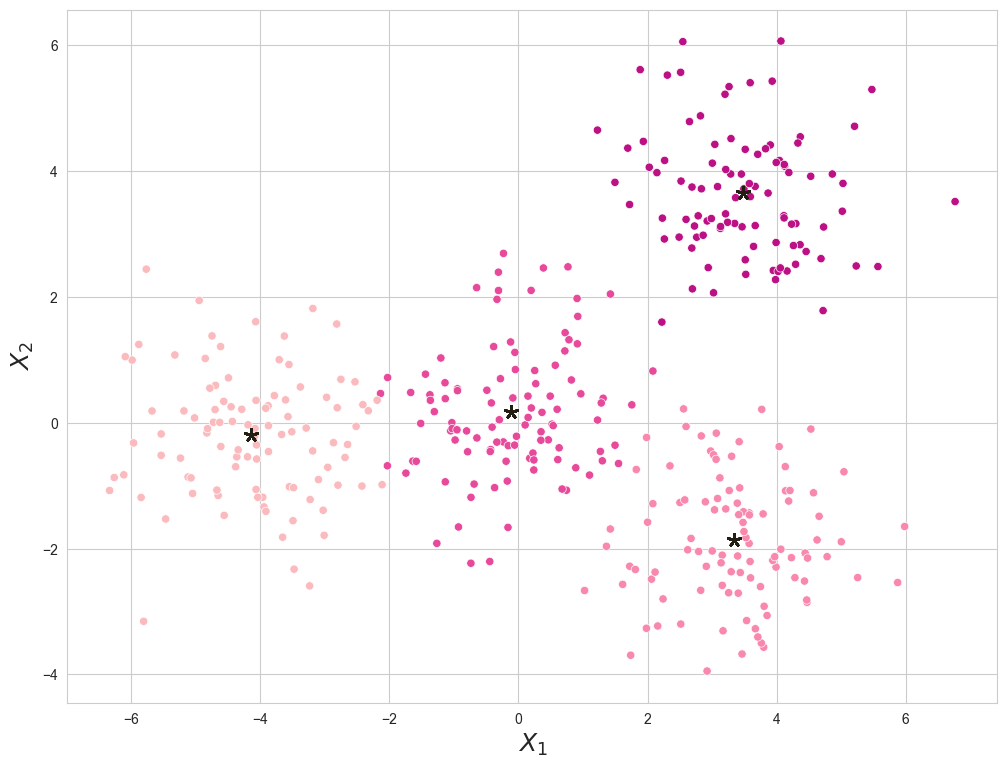

random initialization, 50 iterations:
The mean Silhouette Coefficient: 0.5644544929974866
Rand index adjusted for chance: 0.9340183005202644
Adjusted Mutual Information: 0.9117474366398979


In [9]:
initialization = "random"
iterations = 50

my_k_means_random = MyKMeans(n_clusters=4, visualize=True, init=initialization, max_iter=iterations)
my_k_means_random.fit(X)
pred_random = my_k_means_random.predict(X)

print(
    f'{initialization} initialization, {iterations} iterations:'
    '\n'
    f'The mean Silhouette Coefficient: {silhouette_score(X, pred_random)}'
    '\n'
    f'Rand index adjusted for chance: {adjusted_rand_score(true_labels, pred_random)}'
    '\n'
    f'Adjusted Mutual Information: {adjusted_mutual_info_score(true_labels, pred_random)}'
    )

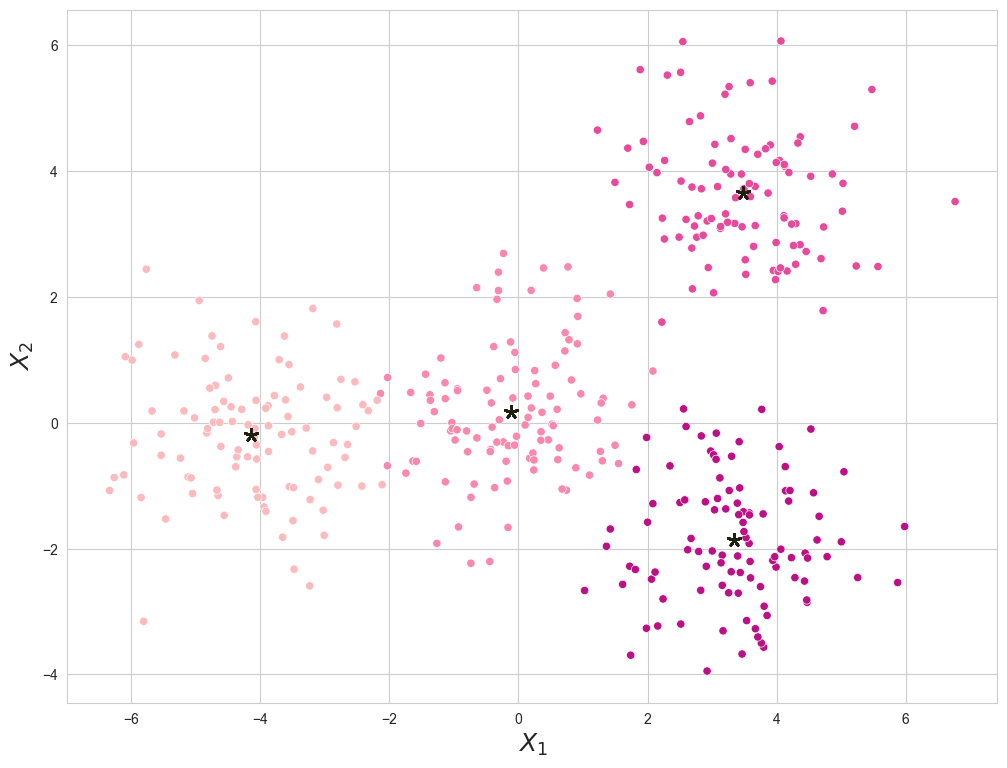

sample initialization, 50 iterations:
The mean Silhouette Coefficient: 0.5644544929974866
Rand index adjusted for chance: 0.9340183005202644
Adjusted Mutual Information: 0.9117474366398978


In [10]:
initialization = "sample"
iterations = 50

my_k_means_sample = MyKMeans(n_clusters=4, visualize=True, init=initialization, max_iter=iterations)
my_k_means_sample.fit(X)
pred_sample = my_k_means_sample.predict(X)

print(
    f'{initialization} initialization, {iterations} iterations:'
    '\n'
    f'The mean Silhouette Coefficient: {silhouette_score(X, pred_sample)}'
    '\n'
    f'Rand index adjusted for chance: {adjusted_rand_score(true_labels, pred_sample)}'
    '\n'
    f'Adjusted Mutual Information: {adjusted_mutual_info_score(true_labels, pred_sample)}'
    )

As we can see, the more iterations, the less initialization type does affect the model quality. 

### Задание 2. Подбираем лучшую иерархическую кластеризацию

5 баллов

На лекции были рассмотрены различные расстояния, которые могут служить метриками различия между объектами. Также мы разобрали несколько алгоритмов кластеризации, в том числе и иерархическую. Часто может быть непонятно, какой алгоритм и какую метрику расстояния нужно взять. Давайте упростим себе жизнь и напишем функцию `algorithm_selection`, которая будет на основании переданных ей:

* метрик расстояния (можно брать все, что было на лекциях, минимум 4)
* параметра `linkage` ('average', 'single', 'complete')
* и метрик качества кластеризации ('Homogeneity', 'Completeness', 'V-measure', 'Silhouette')

будет выводить итоговую таблицу, в которую войдут столбцы:
* distance (метрика расстояния)
* linkage (алгоритм иерархической кластеризации)
* homogenity
* completeness
* v_measure
* silhouette

В результате по этой таблице, нужно сделать вывод о том, какой алгоритм кластеризации и с какими гиперпараметрами лучше всего сработал.

Загрузим наши данные:

In [11]:
data = load_digits()
X, y = data.data, data.target

Let's take a look at the shapes of X and y, how many classes are present and visualize them and see the representability of classes.

In [12]:
y.dtype

dtype('int64')

In [13]:
print(f'X shape: {X.shape}, y shape: {y.shape}, number of classes: {np.unique(y).shape[0]}, class labels: {np.unique(y)}')

X shape: (1797, 64), y shape: (1797,), number of classes: 10, class labels: [0 1 2 3 4 5 6 7 8 9]


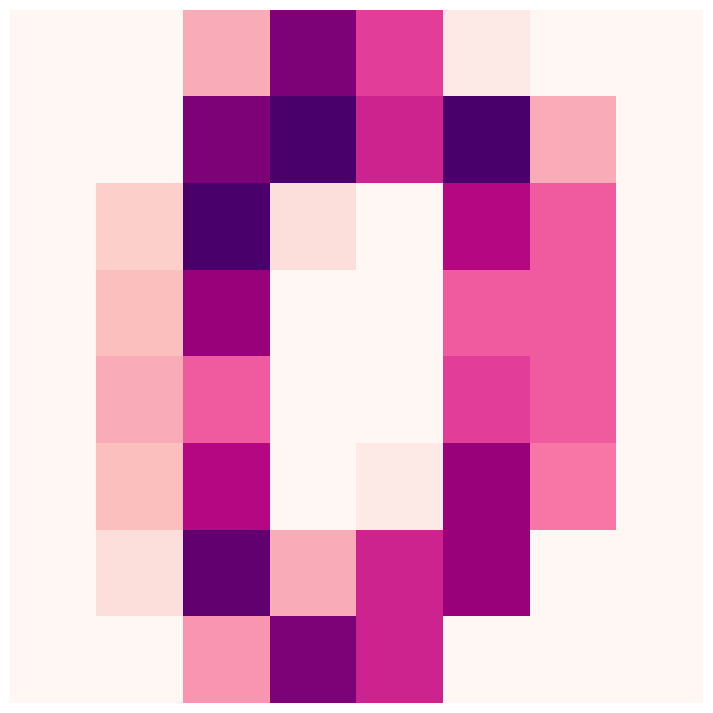

In [14]:
plt.imshow(X[0].reshape(8, 8).astype(int), cmap="RdPu")
plt.axis("off");

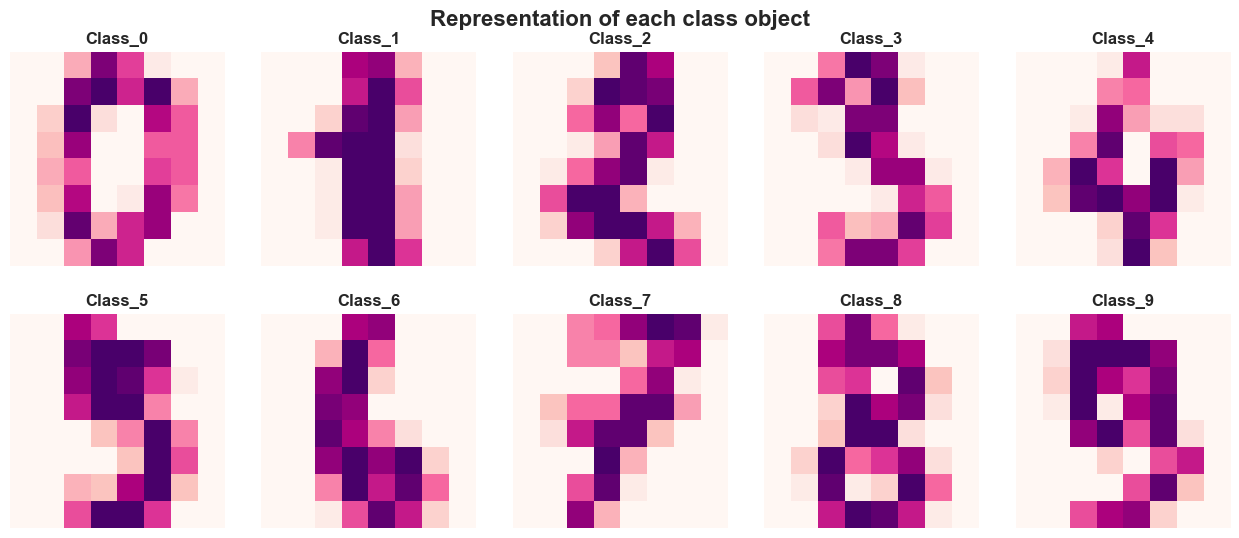

In [15]:
fig, axes = plt.subplots(2, 5, figsize=(13.5, 6))

fig.suptitle("Representation of each class object", size=16, weight="bold", y=0.91)

class_nums = list(map(int, range(10)))

object_class = 0
for row in axes:
    for col in row:
        object_index = np.where(y == object_class)[0][0]
        image = X[object_index].reshape(8, 8)
        col.set_title(f'Class_{object_class}', weight='bold', size=12)
        col.set_axis_off()
        col.imshow(image, cmap='RdPu')
        object_class += 1
plt.subplots_adjust(wspace=-0.3)
fig.tight_layout(pad=2.0)

''

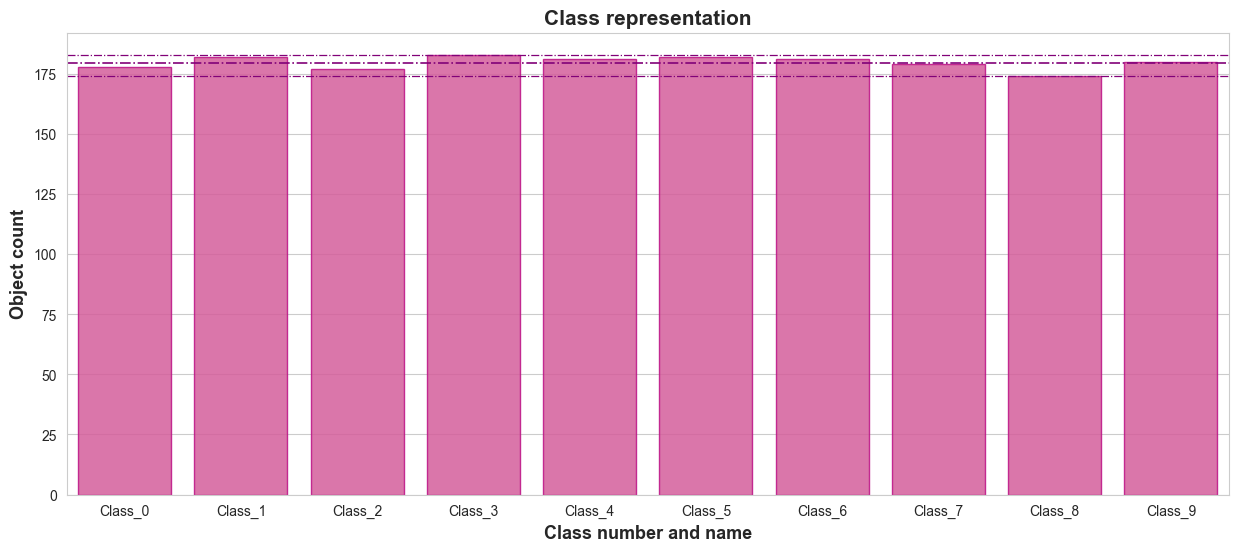

In [16]:
_, object_count = np.unique(y, return_counts=True)

plt.figure(figsize=(15, 6))
sns.barplot(x=list(map(lambda x: f'Class_{class_nums.index(x)}', class_nums)), 
            y=object_count,
            color=sns.color_palette("RdPu")[3],
            edgecolor=sns.color_palette("RdPu")[4],
            alpha=0.85)
plt.xlabel("Class number and name", size=13, weight="bold")
plt.ylabel("Object count", size=13, weight="bold")
plt.title("Class representation", size=15, weight="bold")
plt.axhline(y=object_count.min(), color=sns.color_palette("RdPu")[5], linestyle='-.', linewidth=0.9)
plt.axhline(y=object_count.max(), color=sns.color_palette("RdPu")[5], linestyle='-.', linewidth=0.9)
plt.axhline(y=object_count.mean(), color=sns.color_palette("RdPu")[5], linestyle='-.', linewidth=1.2)
;

Работать будем с изображениями рукописных цифр. Тут все похоже на данные для 1 домашнего задания, каждая картинка представлена вектором из 64 элементов (числа от 0 до 255). Чтобы ее нарисовать мы должны сделать `reshape` в картинку 8 на 8 пикселей. Вам нужно будет выбрать наилучший способ кластеризации при помощи функции `algorithm_selection`, которую вы реализуете. Для некоторых метрик кластеризации требуются метки **классов** объектов (они хранятся в переменной `y`).

##### YOUR TURN TO CODE

In [17]:
def algorithm_selection(X, distances, algorithms, metrics, cluster_number):
    """
    Для заданных алгоримов кластеризации и гиперпараметров 
    считает различные метрики кластеризации
        :param X: наши данные (n_samples, n_features)
        :param distances: список возможных метрик расстояния
        :param algorithm: параметр linkage ('average', 'single', 'complete')
        :param metrics: список возможных метрик качества кластеризации
        :param cluster_number: количество кластеров - добавила, чтобы потом для клеток использовать, и вообще норм было варьировать вводные данные
    :return compare_dataframe: таблица с метриками кластеризации
    """

    """
    YOUR CODE IS HERE
    """

    col_names = list(("distance", "linkage"))
    col_names.extend(sorted(metrics))
    compare_dataframe = pd.DataFrame()

    for distance in distances:
        for algorithm in algorithms:
            metric_result = list()

            if distance == "chi-square":
                chi2_distances = chi2_kernel(X)
                np.fill_diagonal(chi2_distances, 0)
                alg_clust = AgglomerativeClustering(
                    n_clusters=cluster_number, 
                    affinity='precomputed', 
                    linkage=algorithm)
                prediction = alg_clust.fit_predict(chi2_distances)
                if "silhouette" in metrics:
                    silhouette = silhouette_score(chi2_distances, prediction, metric='precomputed')
            else:

                alg_clust = AgglomerativeClustering(
                    n_clusters=cluster_number, 
                    affinity=distance, linkage=algorithm)
                prediction = alg_clust.fit_predict(X)
                if "silhouette" in metrics:
                    silhouette = silhouette_score(X, prediction, metric=distance)
            
            if "completeness" in metrics:
                completeness = completeness_score(y, prediction)
                metric_result.append(completeness)
            if "homogenity" in metrics:
                homogeneity = homogeneity_score(y, prediction)
                metric_result.append(homogeneity)
            if "silhouette" in metrics:
                metric_result.append(silhouette)
            if "v_measure" in metrics:
                v_measure = v_measure_score(y, prediction)
                metric_result.append(v_measure)

            new_row = list((distance, algorithm))
            new_row.extend(metric_result)
            compare_dataframe = compare_dataframe.append(pd.Series(new_row), ignore_index=True)
    compare_dataframe.set_axis(col_names, axis=1, inplace=True)
    
    return compare_dataframe


In [18]:
distances = ["euclidean", "manhattan", "canberra", "chi-square", "cosine"]
linkages = ["average", "single", "complete"]
metrics = ["homogenity", "completeness", "v_measure", "silhouette"]

In [19]:
algos_selection = algorithm_selection(X, distances, linkages, metrics, np.unique(y).shape[0])
algos_selection

distance   linkage  completeness  homogenity  silhouette  v_measure
0    euclidean   average      0.782342    0.655393    0.146625   0.713263
1    euclidean    single      0.273755    0.005056   -0.133621   0.009929
2    euclidean  complete      0.637772    0.590549    0.119271   0.613253
3    manhattan   average      0.778942    0.566751    0.105238   0.656117
4    manhattan    single      0.276237    0.005102   -0.203816   0.010019
5    manhattan  complete      0.686109    0.646372    0.160617   0.665648
6     canberra   average      0.779789    0.573860    0.108401   0.661161
7     canberra    single      0.280506    0.006144   -0.157872   0.012025
8     canberra  complete      0.561588    0.528702    0.104411   0.544649
9   chi-square   average      0.003473    0.003367   -0.750211   0.003419
10  chi-square    single      0.276560    0.005108   -0.994992   0.010031
11  chi-square  complete      0.003609    0.003565   -0.721485   0.003587
12      cosine   average      0.808762    0.648268    0.218229   0.719676
13      cosine    single      0.273389    0.005050   -0.281789   0.009916
14      cosine  complete      0.577415    0.528727    0.144179   0.551999

In [20]:
algos_selection[["homogenity", "completeness", "v_measure", "silhouette"]].idxmax()

homogenity       0
completeness    12
v_measure       12
silhouette      12
dtype: int64

In [21]:
algos_selection.loc[[12]]

distance  linkage  completeness  homogenity  silhouette  v_measure
12   cosine  average      0.808762    0.648268    0.218229   0.719676

In [22]:
algos_selection.loc[[0]]

distance  linkage  completeness  homogenity  silhouette  v_measure
0  euclidean  average      0.782342    0.655393    0.146625   0.713263

Okay, so we see that most of the metrics except homogeneity score are best with following parameters: cosine distances + average linkage (homogeneity score is still not bad), except for homogeneity score which is better if euclidean distances + average linkage (completeness, silhouette and v_measure are still not bad). 

So, I'd choose the hyperparameter combination between these two, preferrably, cosine distances + average linkage.

### Задание 3. Аннотация клеточных типов

суммарно 10 баллов

В этом задании вам предстоит применять полученные знания о кластеризации для аннотации данных, полученных при помощи проточной цитометрии. Каждая строка в данных это одна клетка, столбцы **FSC-A**, **SSC-A** косвенным образом свидетельствуют о размере клеток, остальные показывают интенсивность флуоресценции различных поверхностных маркеров. Ваша задача определить для каждой клетки, к какому типу она относится.

#### 3.1. EDA

1.5 балла

Проведите EDA:

1. Посмотрите на данные (можно попробовать метод `describe`)
2. Сколько у нас клеток / признаков
3. Постройте распределения каждого признака (есть ли очевинные выбросы?)

In [23]:
fc_data = pd.read_csv(join(DATA_PATH, "flow_c_data.csv"), index_col=0)

##### YOUR TURN TO CODE:

In [24]:
fc_data.head()

FSC-A     SSC-A    HLA-DR       CD3      CD45      CD14      CD56  \
0  0.722199  0.154232  0.494449  0.512853  4.057328  1.019255  4.007273   
1  0.751073  0.114618  4.671924  0.822042  4.933149  0.159388 -0.216407   
2  1.108188  0.150011 -0.422857  4.006353  5.616384  0.519223  0.783077   
3  0.553310  0.119929  0.345968  3.332310  5.260935  1.481229  0.264846   
4  0.774884  0.076984  4.984963  0.885501  4.562367  0.217117  0.086279   

       CD19     CD11c  
0 -1.406912  0.384406  
1  6.034845  0.577039  
2 -0.318668 -0.493832  
3  0.694883  3.416960  
4  5.563345  0.471591

In [25]:
fc_data.shape # 10000 cells, 9 features

(10000, 9)

In [26]:
fc_data.isna().sum() # great, no NAs to care about

FSC-A     0
SSC-A     0
HLA-DR    0
CD3       0
CD45      0
CD14      0
CD56      0
CD19      0
CD11c     0
dtype: int64

In [27]:
fc_data.describe()

FSC-A         SSC-A        HLA-DR           CD3          CD45  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean       0.962458      0.165415      1.791579      3.280391      5.169845   
std        0.500012      0.190773      2.027281      2.112079      0.518247   
min        0.144786      0.021657     -7.634172     -2.517639     -8.329666   
25%        0.798804      0.105550      0.275056      1.401943      4.922227   
50%        0.908574      0.130543      1.194313      4.373660      5.234119   
75%        1.052034      0.162536      3.696976      4.842212      5.481218   
max       42.954485     15.460997     12.946668     13.844391     13.710922   

               CD14          CD56          CD19         CD11c  
count  10000.000000  10000.000000  10000.000000  10000.000000  
mean       1.097182      0.412223      1.219683      0.569898  
std        1.375876      1.176967      2.285305      1.502445  
min       -8.833883    -12.358701     -9.640775    -11.085437  
25%        0.389746     -0.195978     -0.146948     -0.498781  
50%        0.672853      0.053267      0.244121      0.272297  
75%        1.065076      0.378576      0.908374      1.220576  
max        6.294236      6.461899      7.208721      6.840864

First, let's see how the data is distributed trying to identify outliers.

In [28]:
fc_data.columns

Index(['FSC-A', 'SSC-A', 'HLA-DR', 'CD3', 'CD45', 'CD14', 'CD56', 'CD19',
       'CD11c'],
      dtype='object')

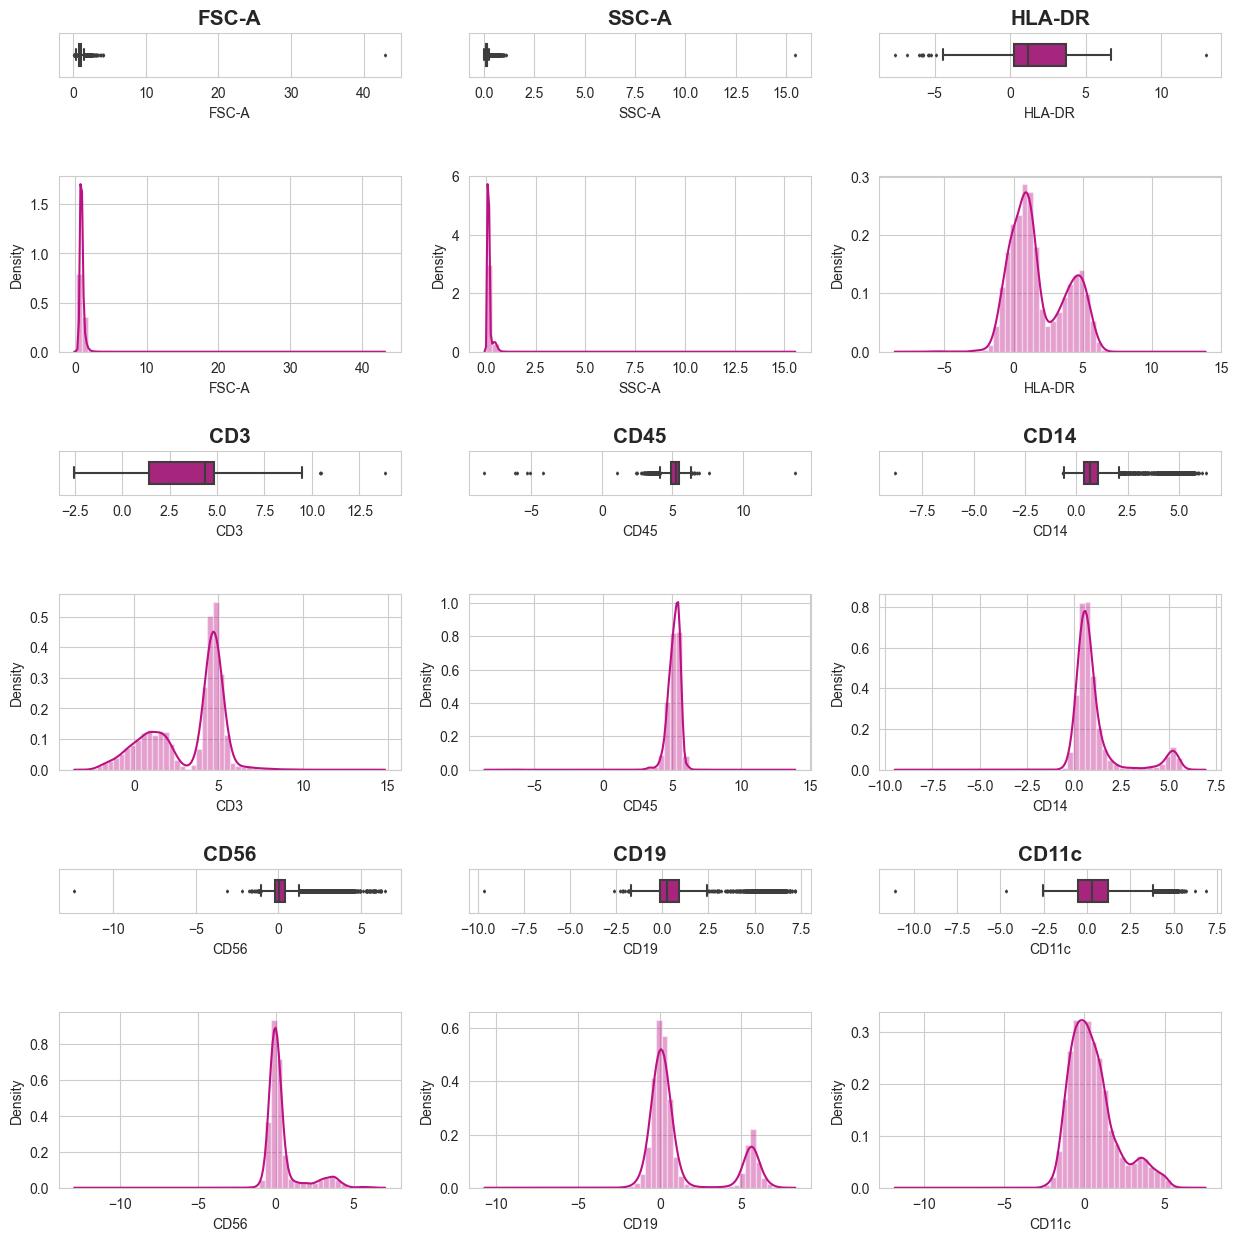

In [29]:
fig, axes = plt.subplots(6, 3, figsize=(15, 15), gridspec_kw={"height_ratios": [1, 4] * 3})

idx=0
for i in list(range(6))[::2]:
    for j in range(3):
        axes[i][j].set_title(f'{fc_data.columns[idx]}', size=15, weight='bold')
        sns.boxplot(fc_data, x=fc_data.columns[idx], width=0.5, ax=axes[i][j], color=sns.color_palette("RdPu")[4], fliersize=1.5)
        sns.distplot(fc_data[fc_data.columns[idx]], ax=axes[i + 1][j], color=sns.color_palette("RdPu")[4])
        idx += 1
fig.subplots_adjust(hspace=0.9)

Some obviously outlying observations exclusion.

In [30]:
outliers = fc_data[
    (fc_data["FSC-A"] > 30) 
    | (fc_data["SSC-A"] > 5)
    | (fc_data["HLA-DR"] < -5)
    | (fc_data["HLA-DR"] > 10)
    | (fc_data["CD3"] > 10)
    | (fc_data["CD45"] < 0)
    | (fc_data["CD45"] > 10)
    | (fc_data["CD14"] < -1)
    | (fc_data["CD56"] < -5)
    | (fc_data["CD19"] < -5)
    | (fc_data["CD11c"] < -3)
    ]
print(f'{outliers.shape[0]} outliers identified')
fc_data_cleared = fc_data.drop(outliers.index)

11 outliers identified


Have to see feature distribution again. Looks better in terms of outliers, obviously not normally distributed though but anyway it's not crucial for clustering.

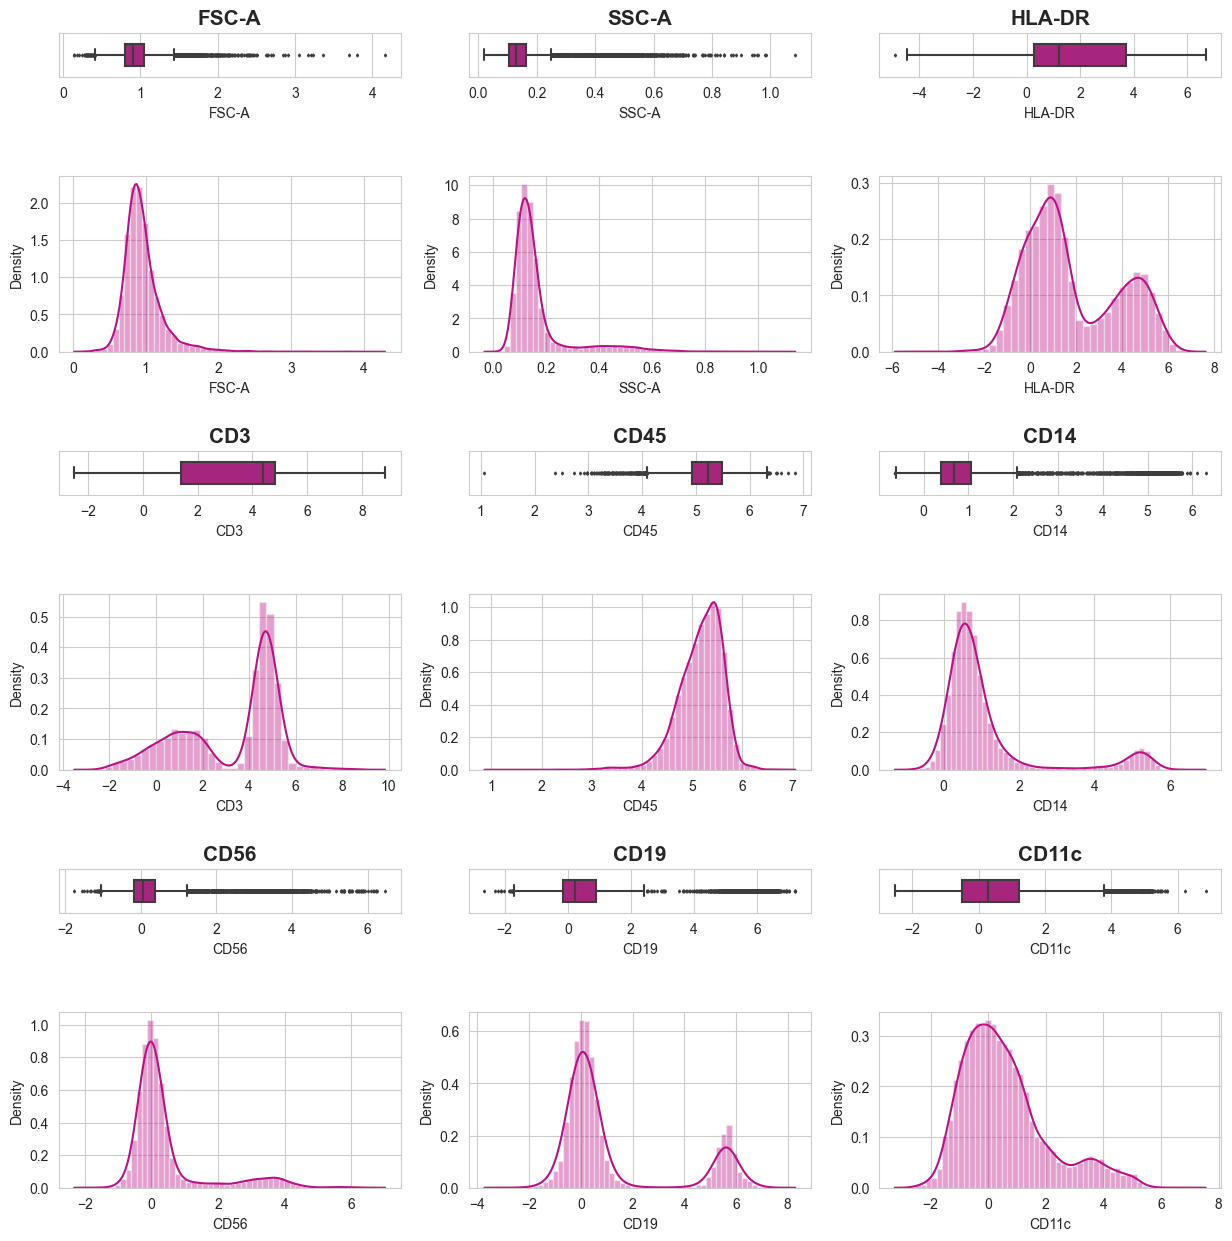

In [31]:
fig, axes = plt.subplots(6, 3, figsize=(15, 15), gridspec_kw={"height_ratios": [1, 4] * 3})

idx=0
for i in list(range(6))[::2]:
    for j in range(3):
        axes[i][j].set_title(f'{fc_data_cleared.columns[idx]}', size=15, weight='bold')
        sns.boxplot(fc_data_cleared, x=fc_data_cleared.columns[idx], width=0.5, ax=axes[i][j], color=sns.color_palette("RdPu")[4], fliersize=1.5)
        sns.distplot(fc_data_cleared[fc_data_cleared.columns[idx]], ax=axes[i + 1][j], color=sns.color_palette("RdPu")[4])
        idx += 1
fig.subplots_adjust(hspace=0.9)

#### 3.2. Кластеризация

4.5 балла

При ручной аннотации клеточных типов обычно поступают следующим образом:

1. При помощи методов понижения размерности рисуют наши наблюдения, чтобы примерно оценить число клеточных типов
2. Проводят кластеризацию наблюдений (для некоторых методов нужно заранее задать число кластеров, поэтому нам как раз помогает п.1)
3. Далее мы считаем, что клетки, которые алгоритм отнес к одному кластеру являются одним клеточным типом (если кластеров больше, чем типов клеток, то возможно, что 2 разных кластера являются одним типом)
4. После чего по интенсивности экспрессии поверхностных маркеров мы присваиваем кластеру клеточный тип

Давайте для начала напишем удобную функцию для визуализации наших многомерных данных в пространстве размерностью 2, делать мы это будем при помощи алгоритма t-SNE.

Поиграться с красивой визуализацией можно [тут](https://distill.pub/2016/misread-tsne/).

In [32]:
def plot_tsne(data, n_iter=1000, 
              perplexity=40, color=None):
    """
    Функция для отрисовки результатов работы t-SNE
        :param data: таблица объекты х признаки
        :param n_iter: число итераций градиентного спуска,
            может быть полезно увеличить, чтобы получить результаты получше
        :param perplexity: 
        :param color: np.array[n_samples] с переменной,
            которой мы хотим покрасить наши наблюдения
        :return tsne_emb: np.array[n_samples, 2] - результаты работы t-SNE
    """
    
    # Сначала сделаем PCA, так как это хорошее начальное приближение для t-SNE
    # позволит алгоритму быстрее сойтись
    pca = PCA().fit(data)
    pca_embedding = pca.transform(data)
    
    # Запустим t-SNE, он выдаст нам для каждого объекта по 2 числа, 
    # которые мы сможем нарисовать
    tnse = TSNE(n_components=2, init=pca_embedding[:, :2], n_jobs=-1,
                n_iter=n_iter, perplexity=perplexity)
    tsne_embedding = tnse.fit_transform(pca_embedding)
    
    sns.scatterplot(x=tsne_embedding[:, 0],
                    y=tsne_embedding[:, 1],
                    hue=color, palette=sns.color_palette("RdPu")[1:])
    plt.xlabel("$TSNE_1$", fontsize=18)
    plt.ylabel("$TSNE_2$", fontsize=18)
    
    # Вернем также результаты t-SNE, так как, если потом захотим перестроить картинку,
    # в таком случае нам не придется ждать заново, просто нарисуем новую с готовыми данными
    
    return tsne_embedding

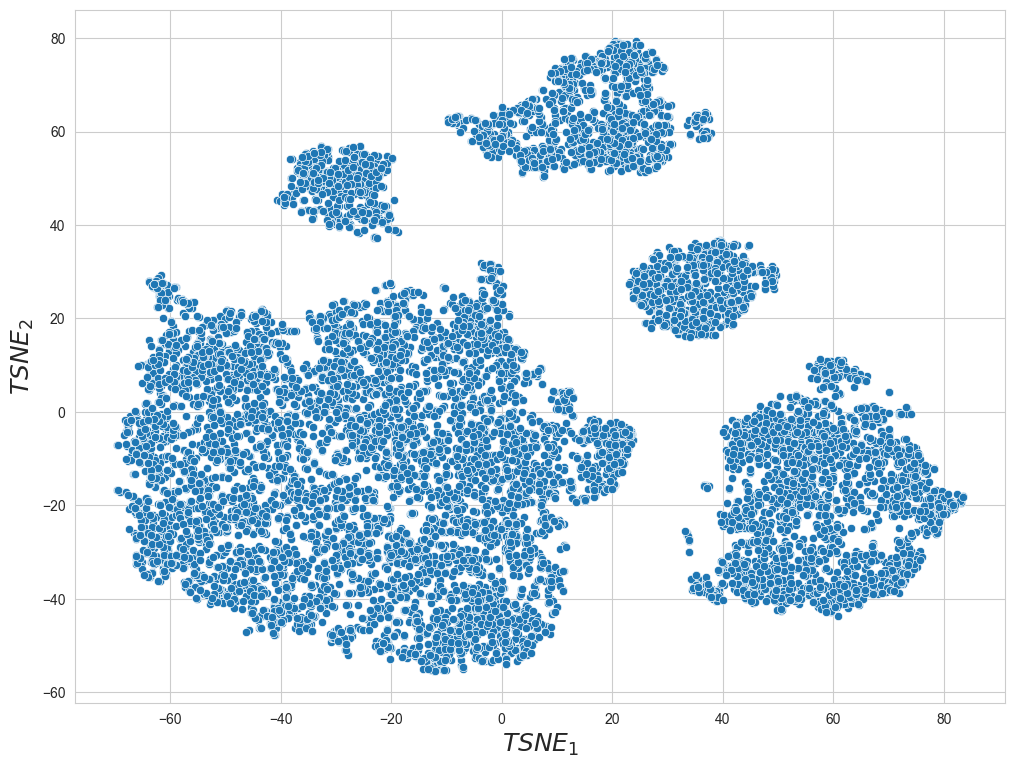

In [33]:
tsne_res = plot_tsne(fc_data_cleared)

Кластеризуйте ваши данные:

1. Попробуйте методы кластеризации из тех, что мы прошли
2. Выберите лучший на основании метрики `silhouette_score` (попробуйте также подобрать гиперпараметры)
3. Присвойте каждому наблюдению метку класса и нарисуйте график t-SNE, покрасив точки метками кластера

In [34]:
distances = ["euclidean", "manhattan", "canberra", "cosine"]
linkages = ["average", "single", "complete"]
metrics = ["silhouette"]

algos_selection = algorithm_selection(fc_data_cleared, distances, linkages, metrics, 4)
algos_selection

distance   linkage  silhouette
0   euclidean   average    0.585574
1   euclidean    single    0.142213
2   euclidean  complete    0.614336
3   manhattan   average    0.610988
4   manhattan    single    0.119002
5   manhattan  complete    0.594853
6    canberra   average    0.178099
7    canberra    single    0.186270
8    canberra  complete    0.110311
9      cosine   average    0.848678
10     cosine    single    0.037162
11     cosine  complete    0.838835

In [35]:
algos_selection.loc[[algos_selection[["silhouette"]].idxmax()[0]]]

distance  linkage  silhouette
9   cosine  average    0.848678

Let's try the best parameters combination. Actually the result looks good.

''

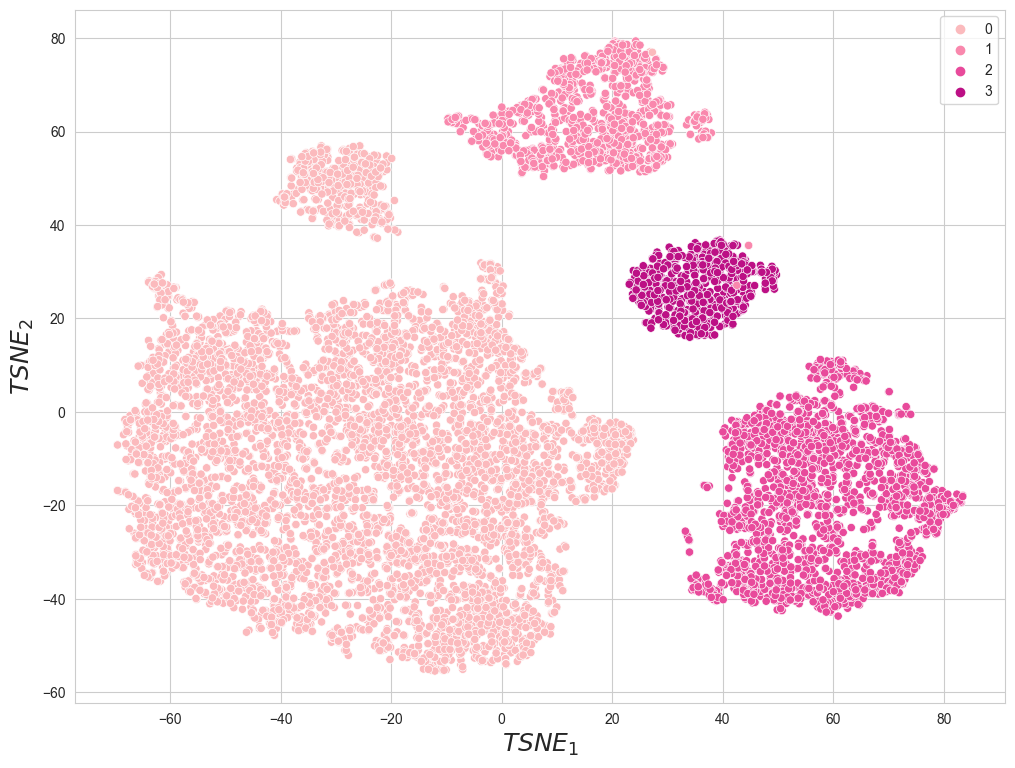

In [36]:
cluster_attempt_1 = AgglomerativeClustering(n_clusters=4, affinity='cosine', linkage='average').fit_predict(fc_data_cleared)
plot_tsne(fc_data_cleared, color=cluster_attempt_1)
;

What about the worst parameters combination? Looks like a failed clustering. Viva la hyperparameters search!

In [37]:
algos_selection.loc[[algos_selection[["silhouette"]].idxmin()[0]]]

distance linkage  silhouette
10   cosine  single    0.037162

''

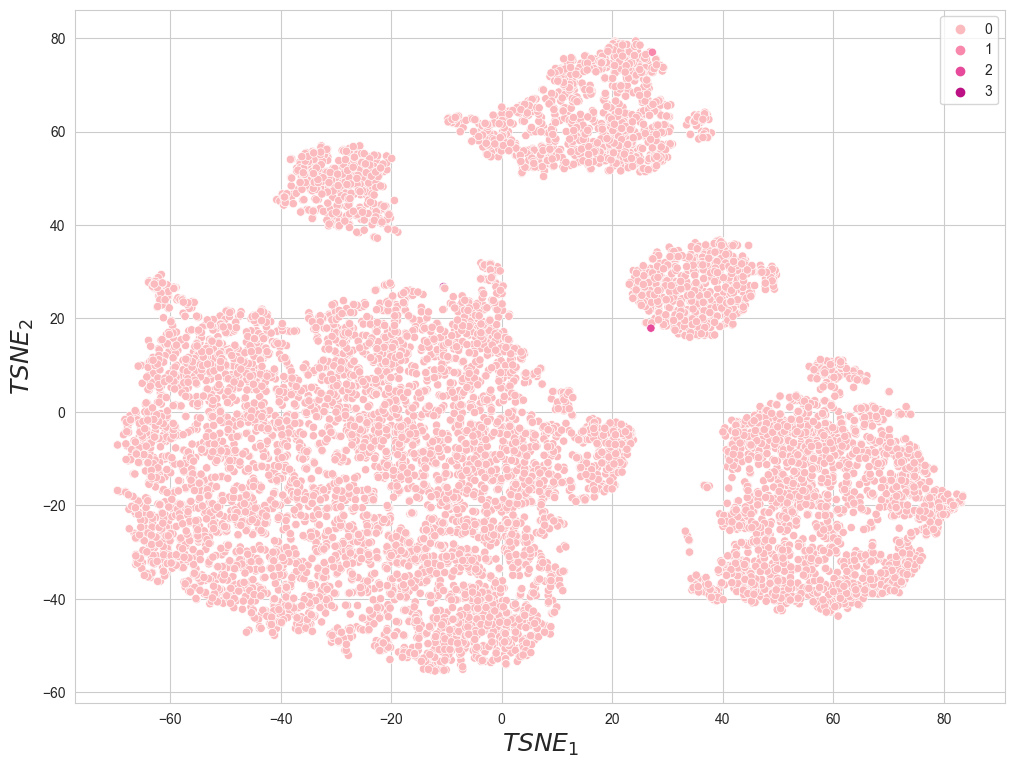

In [38]:
cluster_attempt_2 = AgglomerativeClustering(n_clusters=4, affinity='cosine', linkage='single').fit_predict(fc_data_cleared)
plot_tsne(fc_data_cleared, color=cluster_attempt_2)
;

Удалось ли вам получить ситуацию, где отдельные группы точек покрашены в один цвет?

Actually, thanks to our function for hyperparameters search if the parameters with best silhouette score are chosen, everything is ok.

Okay then I found more algorithms for clustering and wanted to try several; for some of them searched for the best hyperparameters.

KMeans with hyperparameters selection. It seems like algorithm does not impact the silhouette score.

In [39]:
kmeans_algs = ["lloyd", "elkan", "auto", "full"]
kmeans_alg_selection = pd.DataFrame(columns=["algorithm", "silhouette"])
for alg in kmeans_algs:
    pred = KMeans(n_clusters=4, algorithm=alg).fit_predict(fc_data_cleared)
    kmeans_sil = silhouette_score(fc_data_cleared, pred)
    new_row = list((alg, kmeans_sil))
    kmeans_alg_selection = kmeans_alg_selection.append(pd.Series(new_row, index=kmeans_alg_selection.columns), ignore_index=True)
kmeans_alg_selection

algorithm  silhouette
0     lloyd    0.613175
1     elkan    0.613175
2      auto    0.613175
3      full    0.613175

silhouette score: 0.6131747085038285


''

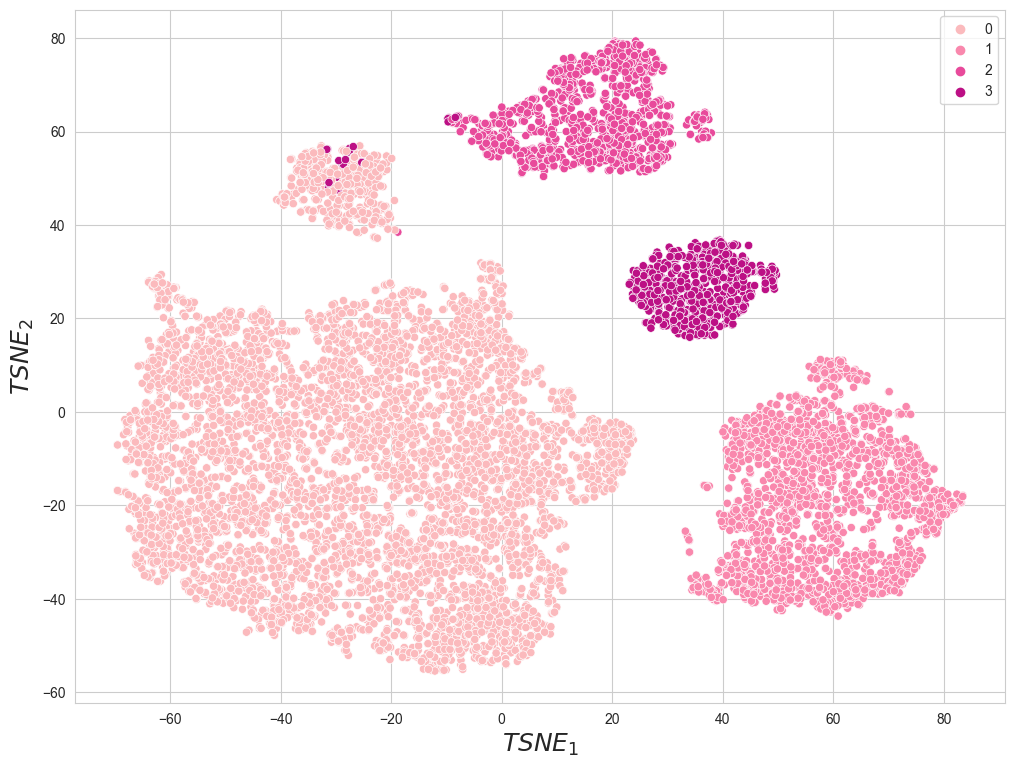

In [40]:
cluster_attempt_3 = KMeans(n_clusters=4).fit_predict(fc_data_cleared)
plot_tsne(fc_data_cleared, color=cluster_attempt_3)
kmeans_sil = silhouette_score(fc_data_cleared, cluster_attempt_3)
print(f'silhouette score: {kmeans_sil}')
;

Birch model. Seemingly good, but silhouette score is not much higher than it was for KMeans.

silhouette score: 0.6143232559027585


''

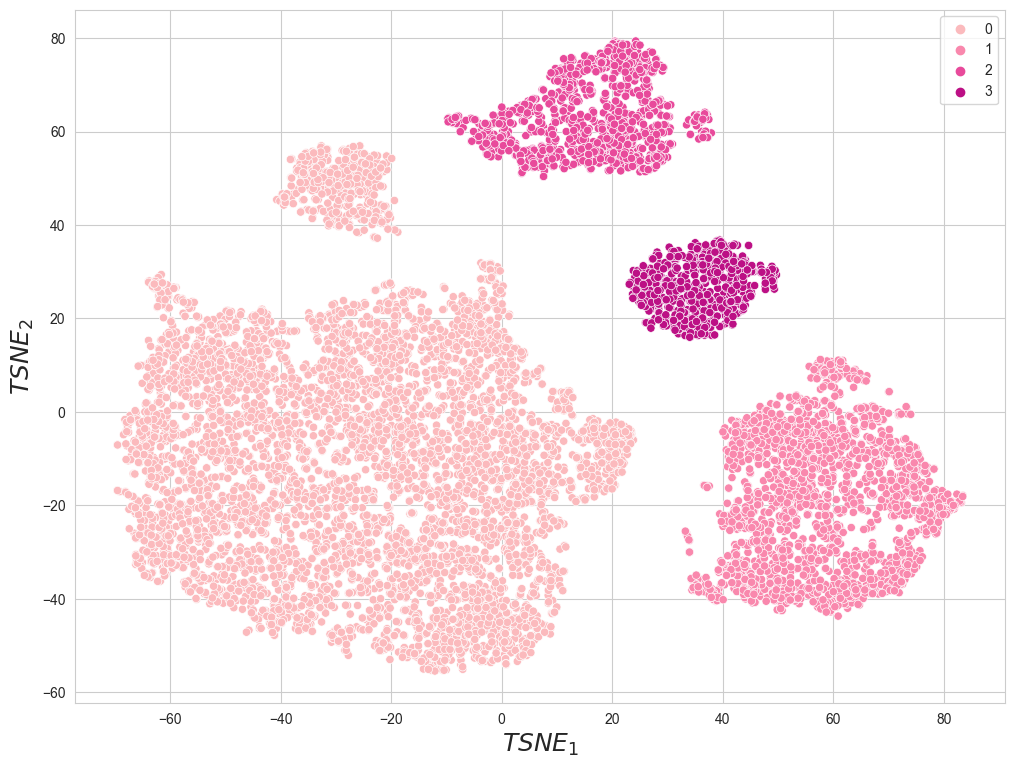

In [41]:
cluster_attempt_4 = Birch(n_clusters=4).fit_predict(fc_data_cleared)
plot_tsne(fc_data_cleared, color=cluster_attempt_4)
birch_sil = silhouette_score(fc_data_cleared, cluster_attempt_4)
print(f'silhouette score: {birch_sil}')
;

DBSCAN with hyperparameter selection.

In [42]:
epses = [0.5, 0.7, 1, 1.5, 2, 2.5, 2.6, 2.7, 2.8, 3]
minsamples = [5, 10, 15, 20, 30]
dbscan_alg_selection = pd.DataFrame(columns=["eps", "min_samples", "silhouette"])
for e in epses:
    for m in minsamples:
        pred = DBSCAN(eps=e, min_samples=m).fit_predict(fc_data_cleared)
        dbscan_sil = silhouette_score(fc_data_cleared, pred)
        new_row = list((e, m, dbscan_sil))
        dbscan_alg_selection = dbscan_alg_selection.append(pd.Series(new_row, index=dbscan_alg_selection.columns), ignore_index=True)
dbscan_alg_selection

eps  min_samples  silhouette
0   0.5          5.0   -0.472569
1   0.5         10.0   -0.391862
2   0.5         15.0   -0.324688
3   0.5         20.0   -0.373553
4   0.5         30.0   -0.377765
5   0.7          5.0   -0.014553
6   0.7         10.0    0.115968
7   0.7         15.0    0.136115
8   0.7         20.0    0.170604
9   0.7         30.0    0.146936
10  1.0          5.0    0.202807
11  1.0         10.0    0.477838
12  1.0         15.0    0.487598
13  1.0         20.0    0.470606
14  1.0         30.0    0.280750
15  1.5          5.0    0.525658
16  1.5         10.0    0.595351
17  1.5         15.0    0.592083
18  1.5         20.0    0.589563
19  1.5         30.0    0.583871
20  2.0          5.0    0.574684
21  2.0         10.0    0.565001
22  2.0         15.0    0.599053
23  2.0         20.0    0.598886
24  2.0         30.0    0.598446
25  2.5          5.0    0.608165
26  2.5         10.0    0.609505
27  2.5         15.0    0.608230
28  2.5         20.0    0.604067
29  2.5         30.0    0.605692
30  2.6          5.0    0.504360
31  2.6         10.0    0.521073
32  2.6         15.0    0.521698
33  2.6         20.0    0.503953
34  2.6         30.0    0.504718
35  2.7          5.0    0.470029
36  2.7         10.0    0.500715
37  2.7         15.0    0.517098
38  2.7         20.0    0.515398
39  2.7         30.0    0.498153
40  2.8          5.0    0.481947
41  2.8         10.0    0.510145
42  2.8         15.0    0.516912
43  2.8         20.0    0.520732
44  2.8         30.0    0.505539
45  3.0          5.0    0.266199
46  3.0         10.0    0.266199
47  3.0         15.0    0.266199
48  3.0         20.0    0.442567
49  3.0         30.0    0.478797

In [43]:
dbscan_alg_selection.loc[[dbscan_alg_selection[["silhouette"]].idxmax()[0]]]


eps  min_samples  silhouette
26  2.5         10.0    0.609505

silhouette score: 0.6095054495899878


''

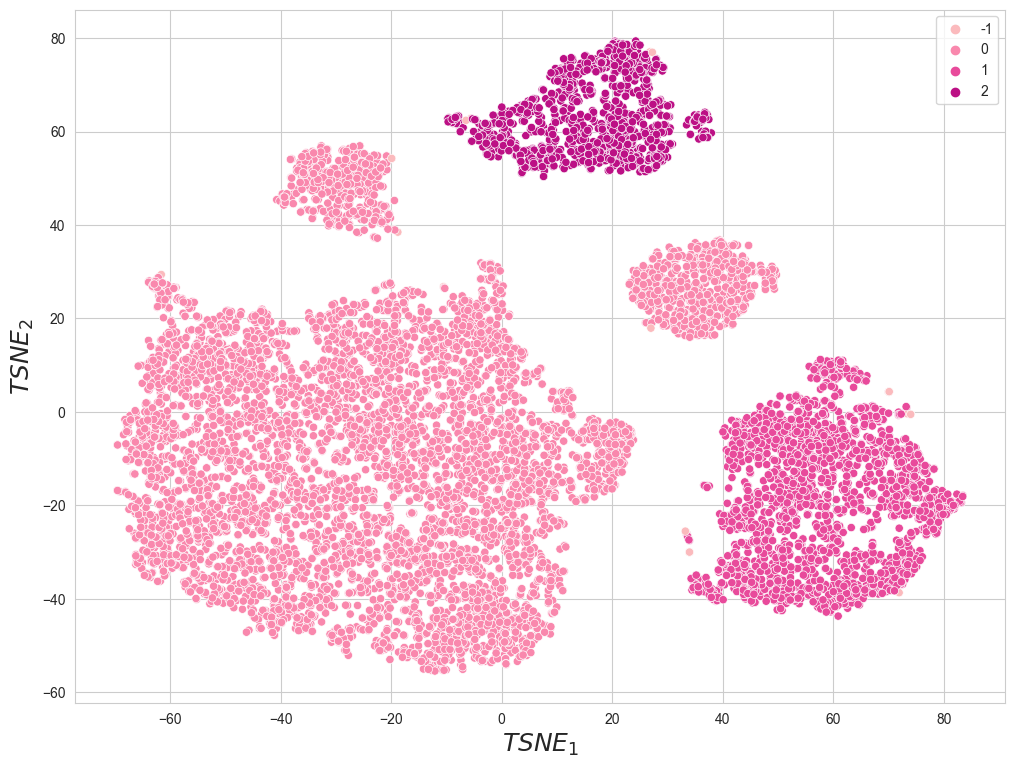

In [44]:
cluster_attempt_5 = DBSCAN(eps=2.5, min_samples=10).fit_predict(fc_data_cleared)
plot_tsne(fc_data_cleared, color=cluster_attempt_5)
dbscan_sil = silhouette_score(fc_data_cleared, cluster_attempt_5)
print(f'silhouette score: {dbscan_sil}')
;

BisectingKMeans.

silhouette score: 0.610081988930565


''

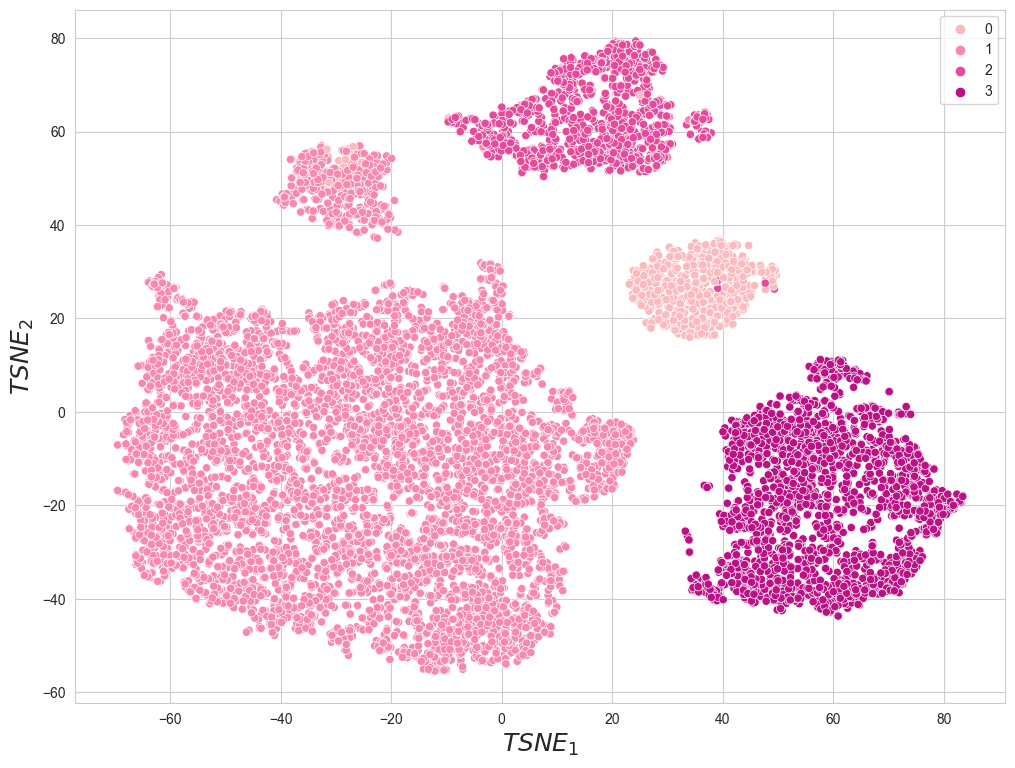

In [45]:
cluster_attempt_6 = BisectingKMeans(n_clusters=4).fit_predict(fc_data_cleared)
plot_tsne(fc_data_cleared, color=cluster_attempt_6)
bisect_sil = silhouette_score(fc_data_cleared, cluster_attempt_6)
print(f'silhouette score: {bisect_sil}')
;

MiniBatchKMeans.

silhouette score: 0.613694891921406


''

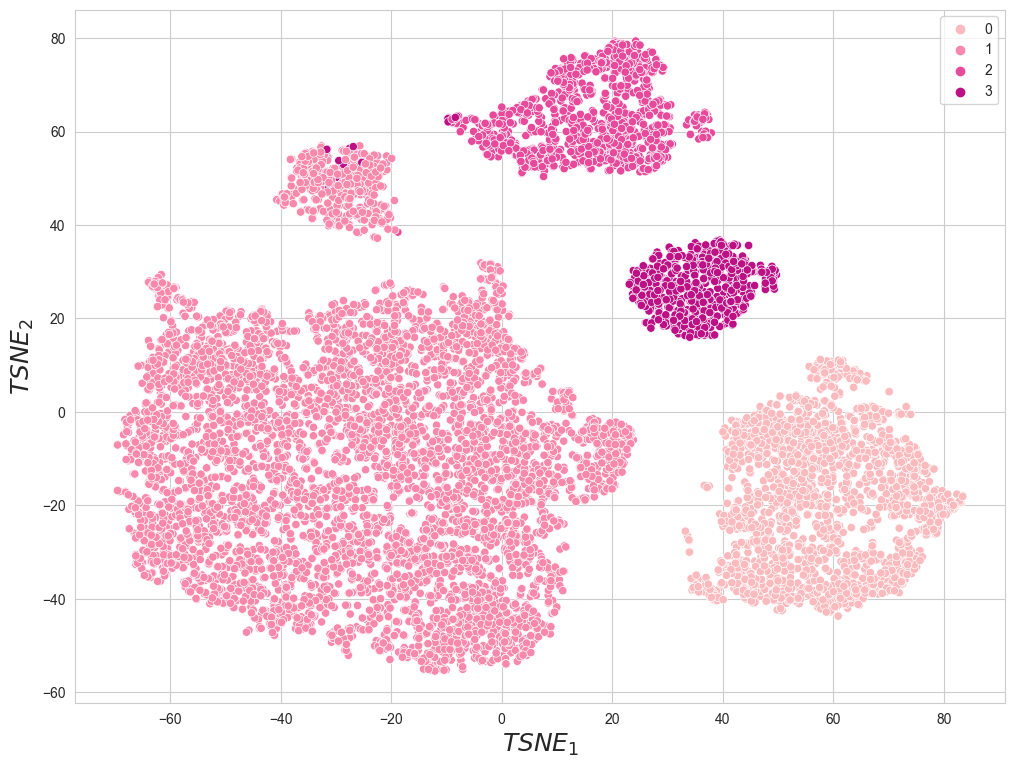

In [46]:
cluster_attempt_7 = MiniBatchKMeans(n_clusters=4).fit_predict(fc_data_cleared)
plot_tsne(fc_data_cleared, color=cluster_attempt_7)
minibatch_sil = silhouette_score(fc_data_cleared, cluster_attempt_7)
print(f'silhouette score: {minibatch_sil}')
;

SpectralClustering with hyperparameters selection.

(runs very slowly due to lots of hyperparameter combinations)

In [47]:
es = ["arpack", "lobpcg", "amg"]
aff = ['cosine', 'chi2', 'linear', 'rbf', 'nearest_neighbors']
nneighb = [5, 10, 15, 20, 30]
als = ["kmeans", "discretize", "cluster_qr"]
specclus_alg_selection = pd.DataFrame(columns=["eigen_solver", "affinity", "n_neighbors", "assign_labels", "silhouette"])
for e in es:
    for a in aff:
        for n in nneighb:
            for al in als:
                try:
                    pred = SpectralClustering(n_clusters=4, eigen_solver=e, 
                                            affinity=a, n_neighbors=n, assign_labels=al).fit_predict(fc_data_cleared)
                    specclus_sil = silhouette_score(fc_data_cleared, pred)
                    new_row = list((e, a, n, al, specclus_sil))
                    specclus_alg_selection = specclus_alg_selection.append(pd.Series(new_row, index=specclus_alg_selection.columns), ignore_index=True)
                except ValueError:
                    continue
specclus_alg_selection

eigen_solver           affinity n_neighbors assign_labels  silhouette
0         arpack             cosine           5        kmeans    0.614579
1         arpack             cosine           5    discretize    0.579351
2         arpack             cosine           5    cluster_qr    0.579911
3         arpack             cosine          10        kmeans    0.614579
4         arpack             cosine          10    discretize    0.579351
..           ...                ...         ...           ...         ...
115       lobpcg  nearest_neighbors          20    discretize    0.614323
116       lobpcg  nearest_neighbors          20    cluster_qr    0.614323
117       lobpcg  nearest_neighbors          30        kmeans    0.614323
118       lobpcg  nearest_neighbors          30    discretize    0.614423
119       lobpcg  nearest_neighbors          30    cluster_qr    0.614423

[120 rows x 5 columns]

In [48]:
specclus_alg_selection.loc[[specclus_alg_selection[["silhouette"]].idxmax()[0]]]

eigen_solver affinity n_neighbors assign_labels  silhouette
15       arpack   linear           5        kmeans    0.614694

silhouette score: 0.6146941826291717


''

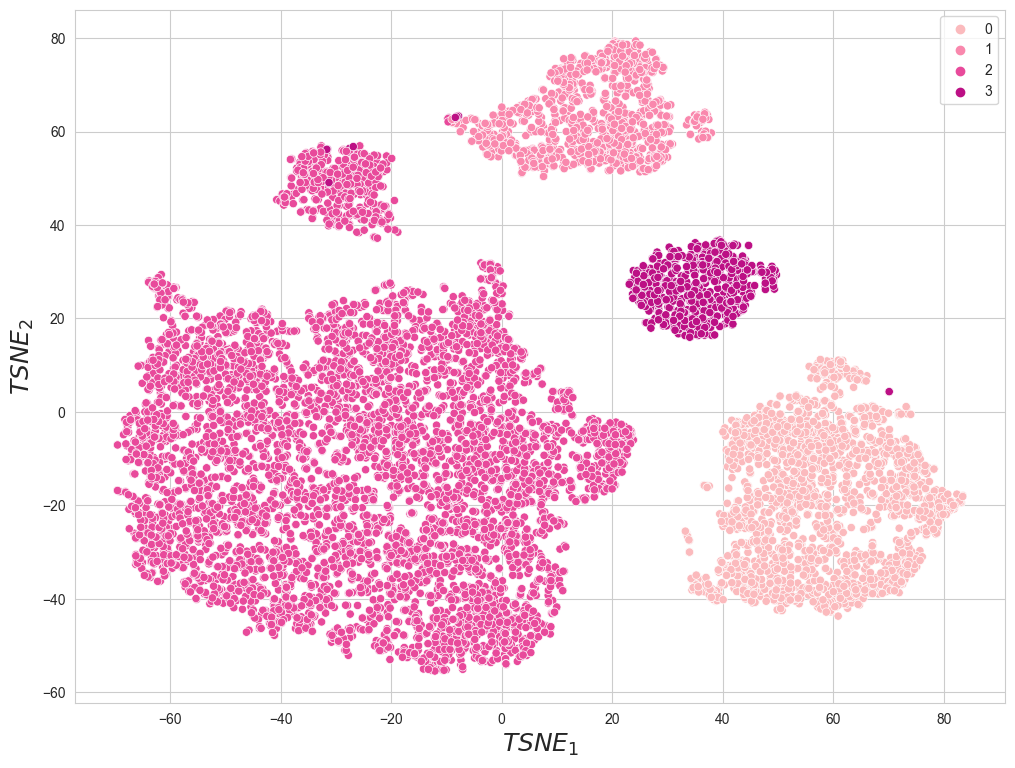

In [49]:
cluster_attempt_8 = SpectralClustering(n_clusters=4, eigen_solver="arpack", affinity="linear", 
                                       n_neighbors=5, assign_labels="kmeans").fit_predict(fc_data_cleared)
plot_tsne(fc_data_cleared, color=cluster_attempt_8)
specclus_sil = silhouette_score(fc_data_cleared, cluster_attempt_8)
print(f'silhouette score: {specclus_sil}')
;

#### 3.3. Аннотация клеточных типов

4 балла

Теперь когда мы подобрали хороший алгоритм кластеризации, можно аннотировать наши клетки. Для этого мы нарисуем t-SNE и покрасим точки в зависимости от интенсивности экспрессии поверхностных маркеров. В датасете присутствуют следующие типы клеток:

* B_cells
* T_cells
* Monocytes
* Other cells

Вам нужно будет выяснить, какие клетки экспрессируют определенные маркеры и присвоить каждому кластеру один из типов клеток.

Для начала нарисуем все это безобразие:

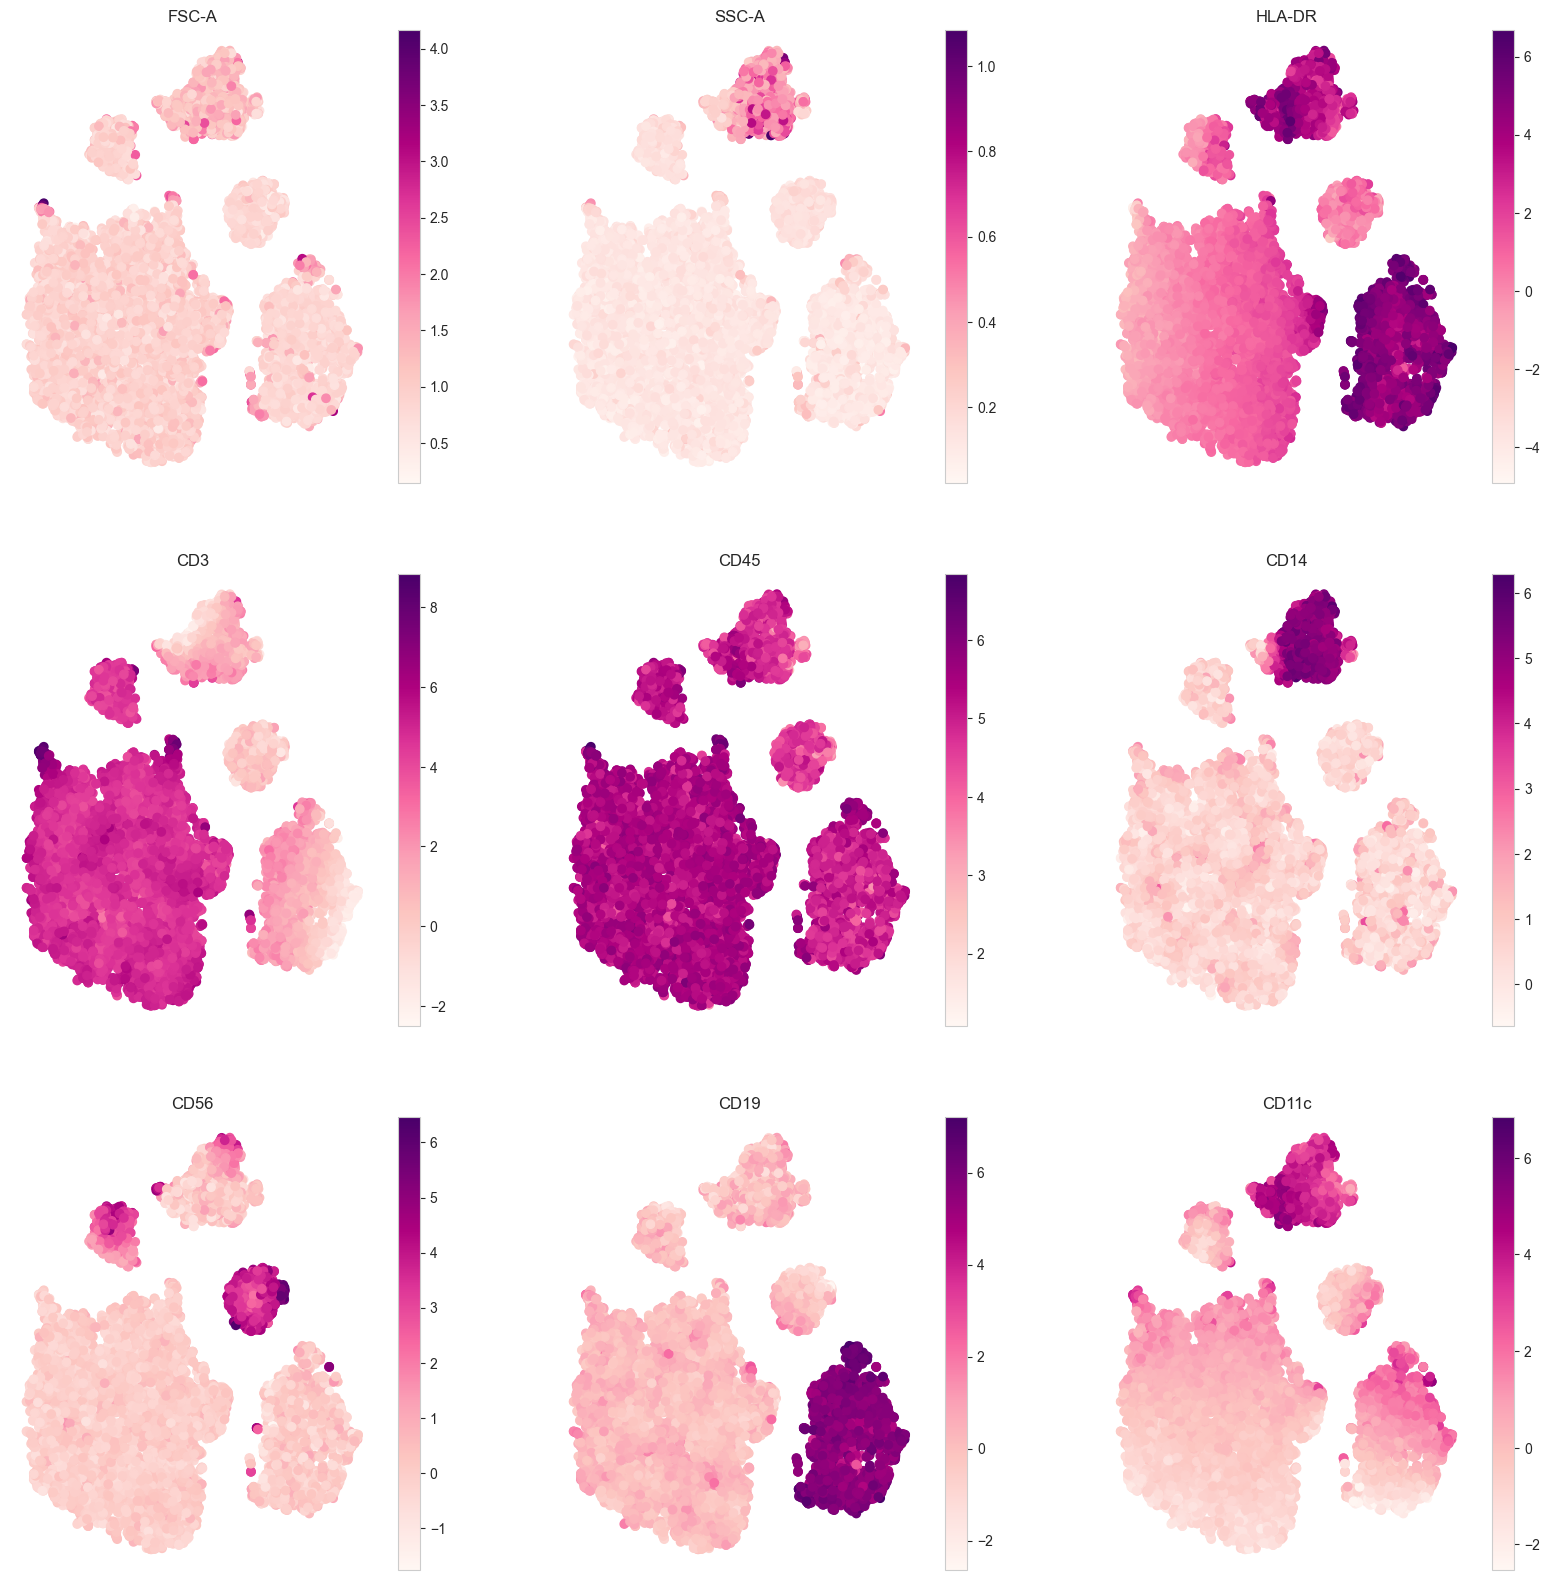

In [50]:
# Результаты t-SNE уже есть в переменной tsne_res
fig, axes = plt.subplots(3, 3, figsize=(20, 20))
for col, ax in zip(fc_data_cleared.columns, axes.ravel()):
    scatter = ax.scatter(tsne_res[:, 0], tsne_res[:, 1], 
                         c=fc_data_cleared[col], cmap="RdPu")
    fig.colorbar(scatter, ax=ax)
    ax.set_title(col)
    ax.grid(False)
    ax.axis("off")

Дальше дело за вами, нужно определить клеточный тип для каждого кластера и записать их как значения в словаре:

 lineage markers for T cells (CD3), B cells (CD19) and monocytes (CD14) 

In [51]:
cell_type_cluster_map = {0: "T_cell", 
                         1: "B_cell", 
                         2: "monocyte", 
                         3: "other"}

In [52]:
clust = AgglomerativeClustering(n_clusters=4, affinity='cosine', linkage='average').fit(fc_data_cleared)

In [53]:
labeled_fc_data = fc_data_cleared.assign(Population=clust.labels_)
labeled_fc_data["Population"] = labeled_fc_data["Population"].map(cell_type_cluster_map)

Посчитайте, как распределены типы клеток:

In [54]:
labeled_fc_data.head()

FSC-A     SSC-A    HLA-DR       CD3      CD45      CD14      CD56  \
0  0.722199  0.154232  0.494449  0.512853  4.057328  1.019255  4.007273   
1  0.751073  0.114618  4.671924  0.822042  4.933149  0.159388 -0.216407   
2  1.108188  0.150011 -0.422857  4.006353  5.616384  0.519223  0.783077   
3  0.553310  0.119929  0.345968  3.332310  5.260935  1.481229  0.264846   
4  0.774884  0.076984  4.984963  0.885501  4.562367  0.217117  0.086279   

       CD19     CD11c Population  
0 -1.406912  0.384406      other  
1  6.034845  0.577039   monocyte  
2 -0.318668 -0.493832     T_cell  
3  0.694883  3.416960     T_cell  
4  5.563345  0.471591   monocyte

In [64]:
labeled_fc_data["Population"].value_counts() # class disbalance detected

T_cell      6222
monocyte    2035
B_cell      1100
other        632
Name: Population, dtype: int64

Сохраните ваши результаты в csv файл, мы сравним их с правильными ответами по метрике `f1_score(average="macro")`, которая хорошо подходит, даже если классы не сбалансированы.

In [56]:
labeled_fc_data.to_csv("../data/labeled_cells.csv")

#### 3.4. Атоматическая аннотация

**дополнительные** 5 баллов

Это задание является дополнительным. Вам нужно построить классификатор клеточных типов на основе размеченных вами данных. Пока что мы прошли не так много разных классификаторов, но уже есть из чего выбирать.

Оцените качество полученной модели при помощи `f1_score(average="macro")`. Попробуйте его улучшить, каким-то образом поработав с дисбалансом классов ([помощь](https://elitedatascience.com/imbalanced-classes)).

First attempt. Without class disbalance correction.

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler

In [67]:
# train-test split

X = labeled_fc_data.drop("Population", axis=1)
y = labeled_fc_data.Population
test_proportion = 0.25
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_proportion, random_state=SEED)

In [68]:
# check that proportion of each class in train and test remains at the setup level (we remember that train_test_split is a random thing)
# see class disbalance, have to fix it for train

frame = {'train': y_train.value_counts(), 'test': y_test.value_counts()}
result = pd.DataFrame(frame)
result["proportion"] = result.test / (result.train + result.test)
result

train  test  proportion
T_cell     4696  1526    0.245259
monocyte   1513   522    0.256511
B_cell      812   288    0.261818
other       470   162    0.256329

The major class in train is T-cell (4696 cells). We have to upsample other three classes up to this number.

In [81]:
train_overall = pd.concat([X_train, y_train], axis=1)

train_all_mon = train_overall[train_overall["Population"] == "monocyte"]
train_all_B = train_overall[train_overall["Population"] == "B_cell"]
train_all_other = train_overall[train_overall["Population"] == "other"]
train_all_T = train_overall[train_overall["Population"] == "T_cell"]

reshape_val = train_all_T.shape[0]

train_all_mon_up = resample(train_all_mon, random_state=SEED, n_samples=reshape_val,replace=True)
train_all_B_up = resample(train_all_B, random_state=SEED, n_samples=reshape_val,replace=True)
train_all_other_up = resample(train_all_other, random_state=SEED, n_samples=reshape_val,replace=True)

train_balanced = pd.concat([train_all_B_up, train_all_T, train_all_mon_up, train_all_other_up])
train_balanced.Population.value_counts()

B_cell      4696
T_cell      4696
monocyte    4696
other       4696
Name: Population, dtype: int64

In [97]:
X_train, y_train = train_balanced.drop("Population", axis=1), train_balanced.Population

Now I want to standardize data.

In [103]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
pd.DataFrame(X_train_scaled).describe()

0             1             2             3             4  \
count  1.878400e+04  1.878400e+04  1.878400e+04  1.878400e+04  1.878400e+04   
mean  -1.331511e-16 -3.631394e-17  1.210465e-16 -6.052323e-17 -6.052323e-17   
std    1.000027e+00  1.000027e+00  1.000027e+00  1.000027e+00  1.000027e+00   
min   -2.833427e+00 -1.198775e+00 -3.230950e+00 -1.958418e+00 -7.761042e+00   
25%   -6.274094e-01 -6.331310e-01 -9.057285e-01 -7.428025e-01 -5.894646e-01   
50%   -2.485926e-01 -4.030355e-01 -7.330673e-02 -2.865904e-01  1.172072e-02   
75%    3.941363e-01  1.139127e-01  9.313643e-01  1.009500e+00  6.915309e-01   
max    9.666798e+00  5.631934e+00  2.068627e+00  3.481183e+00  3.630924e+00   

                  5             6             7             8  
count  1.878400e+04  1.878400e+04  1.878400e+04  1.878400e+04  
mean  -1.210465e-17 -4.841859e-17 -1.210465e-17  1.210465e-16  
std    1.000027e+00  1.000027e+00  1.000027e+00  1.000027e+00  
min   -1.203148e+00 -1.700852e+00 -1.639406e+00 -2.074041e+00  
25%   -6.454102e-01 -7.230285e-01 -6.542683e-01 -7.749901e-01  
50%   -4.689578e-01 -4.941840e-01 -4.531557e-01 -2.333854e-01  
75%    9.250426e-02  9.817381e-01  5.582255e-01  6.737365e-01  
max    2.505861e+00  3.158167e+00  2.321100e+00  2.553138e+00

In [86]:
def find_best_k_accuracy(X_train, y_train, X_test, y_test, params, beau=False):
    """
    Choose the best k for KKNClassifier
    Arguments:
    X_train, np array (num_train_samples, num_features) - train data
    y_train, np array (num_train_samples) - train labels
    X_test, np array (num_test_samples, num_features) - test data
    y_test, np array (num_test_samples) - test labels
    params, list of hyperparameters for KNN, here it is list of k values
    metric, function for metric calculation
    Returns:
    train_metrics the list of metric values on train data set for each k in params
    test_metrics the list of metric values on test data set for each k in params
    """
    
    """
    YOUR CODE IS HERE
    """

    result_train = list()
    result_test = list()

    for neighbour_number in params:
        knn_classifier_search = KNeighborsClassifier(n_neighbors=neighbour_number, weights="distance")
        knn_classifier_search.fit(X_train, y_train)

        prediction_search_train = knn_classifier_search.predict(X_train)
        prediction_search_test = knn_classifier_search.predict(X_test)

        metric_train = accuracy_score(y_train, prediction_search_train)
        metric_test = accuracy_score(y_test, prediction_search_test)

        if beau:
            print(f'K number: {neighbour_number}')
            print(f'Train dataset metric: {metric_train}')
            print(f'Test dataset metric: {metric_test}')

        result_train.append(metric_train)
        result_test.append(metric_test)

    return result_train, result_test

In [104]:
params = list(range(1, 31))
train_metrics, test_metrics = find_best_k_accuracy(X_train_scaled, y_train, X_test, y_test, params, beau=False)

Optimal neighbour number: 2, 11, 12.

''

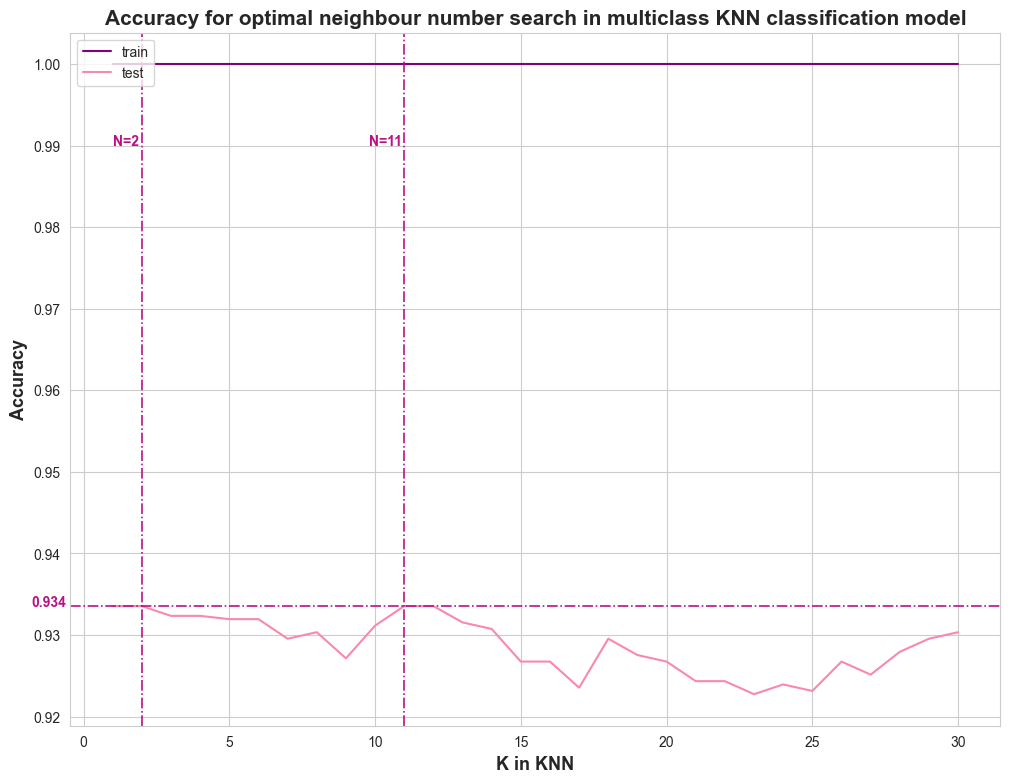

In [153]:
plt.title("Accuracy for optimal neighbour number search in multiclass KNN classification model", size=15, weight="bold")
plt.plot(params, train_metrics, label="train", color=sns.color_palette("RdPu")[5])
plt.plot(params, test_metrics, label="test", color=sns.color_palette("RdPu")[2])
plt.xlabel("K in KNN", size=13, weight="bold")
plt.ylabel("Accuracy", size=13, weight="bold")
plt.axvline(x=2, color=sns.color_palette("RdPu")[4], linestyle='-.', linewidth=1.2)
plt.text(x=1, y=0.99, s="N=2", fontdict={'fontsize': 10, 'fontweight': 'bold', 'color': sns.color_palette("RdPu")[4]})
plt.axvline(x=11, color=sns.color_palette("RdPu")[4], linestyle='-.', linewidth=1.2)
plt.text(x=9.8, y=0.99, s="N=11", fontdict={'fontsize': 10, 'fontweight': 'bold', 'color': sns.color_palette("RdPu")[4]})
plt.axhline(y=max(test_metrics), color=sns.color_palette("RdPu")[4], linestyle='-.', linewidth=1.2)
plt.text(x=-1.8, y=max(test_metrics), s=max(test_metrics).round(3), fontdict={'fontsize': 10, 'fontweight': 'bold', 'color': sns.color_palette("RdPu")[4]})
plt.legend(loc='upper left')
;

In [136]:
mdl = KNeighborsClassifier(n_neighbors=11, weights="distance")
mdl.fit(X_train_scaled, y_train)
len(y_test) - sum(mdl.predict(X_test) == y_test)

166

### Задание 4. Любимое место

дополнительно 0.5 балла

Расскажите о вашем любимом месте, куда бы вы хотели съездить этой весной, если вы уже там бывали, то прикрепите фотографию)

Actually my plans might be pretty spontaneous this spring. Hope that I'll make it to Saint Petersburg to celebrate the BI's B-day. Or maybe Yerevan of Istanbul in blossom of the first flowers at the end of May? Tons of dreams, tons of plans, tons of work at the same time :)

Anyway, I attach a picture for each place.

In [2]:
from IPython.display import Image

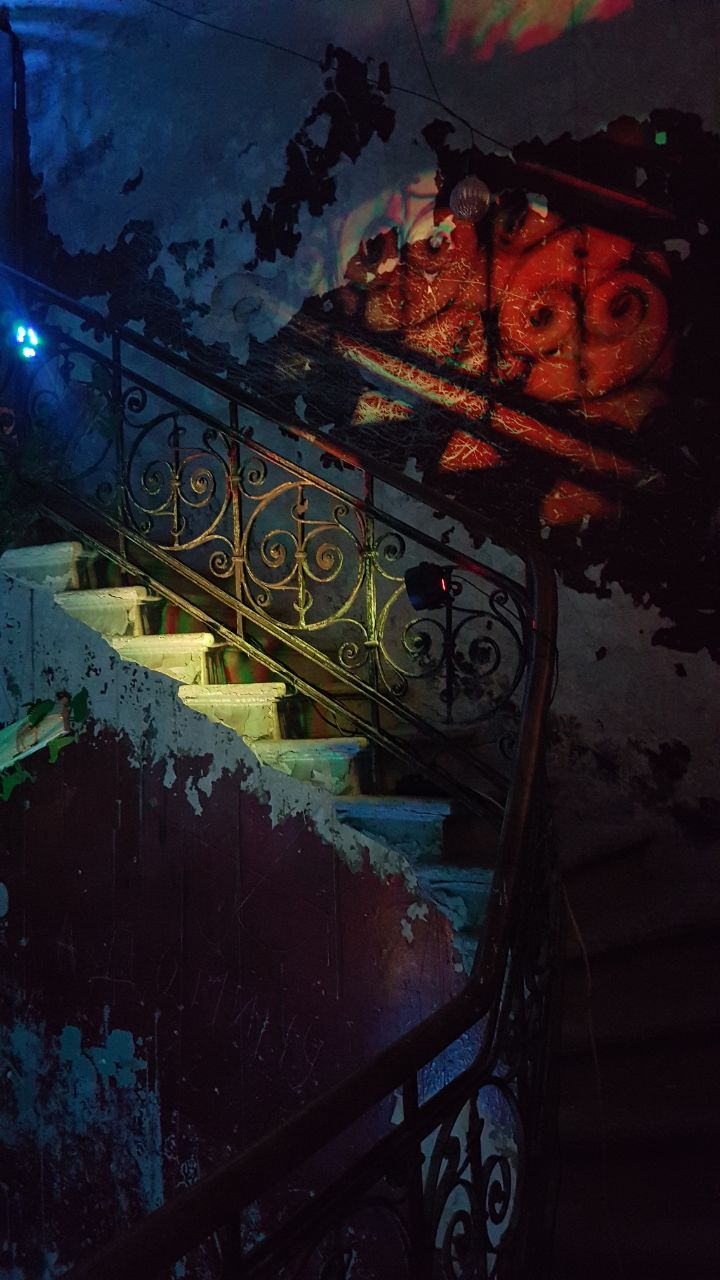

In [155]:
Image("spb.jpg") # one of the most beautiful locations in St Petersburg

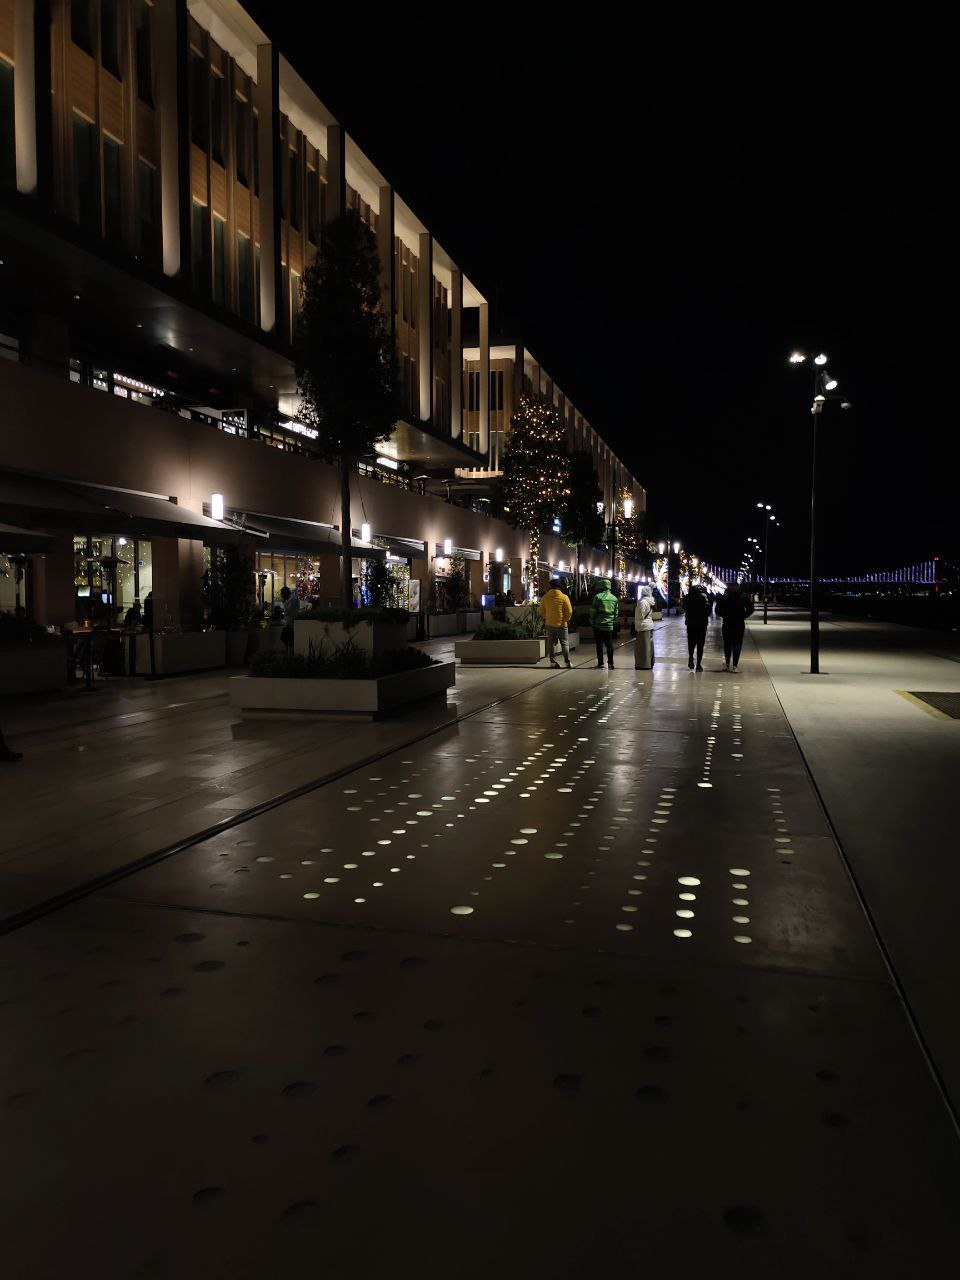

In [157]:
Image("ist.jpg") # a piece of good Istanbul memories

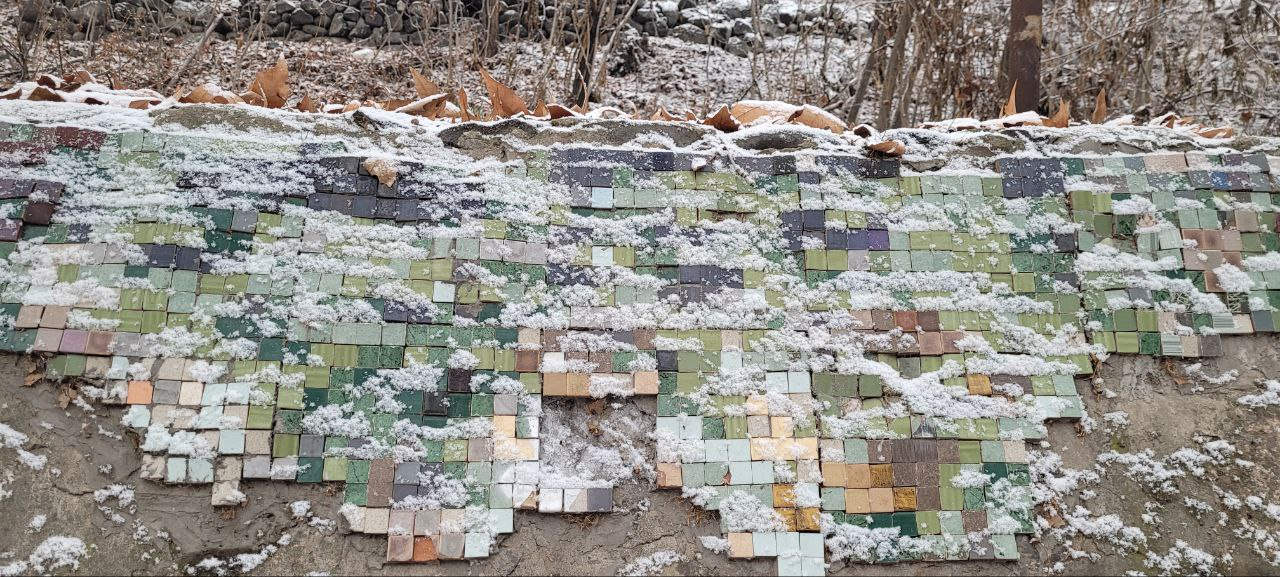

In [158]:
Image("ere.jpg") # tiles from Yerevan (wish my github commits calendar would look like this)

### Therapy time

Напишите здесь ваши впечатления о задании: было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз.

**Ваши мысли:**